In [1]:
import os
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

fire_all = pd.read_csv("data/processed/fire_2024_all.csv")
print("Forme du dataset :", fire_all.shape)
fire_all.head()



Forme du dataset : (90250, 15)


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,type
0,27.72818,9.87200,295.51,0.76,0.77,2024-01-01,3,N20,VIIRS,n,2,277.66,1.24,N,2
1,28.63288,9.77909,301.80,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.05,1.57,N,2
2,28.64012,9.77953,298.65,0.79,0.78,2024-01-01,3,N20,VIIRS,n,2,277.04,1.34,N,2
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141,N20,VIIRS,n,2,257.28,5.21,N,2
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141,N20,VIIRS,n,2,272.08,1.58,N,2


In [11]:
# ============================================
# DATA CLEANING COMPLET 
# ============================================

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Charger les données
fire_all = pd.read_csv("data/processed/fire_2024_all.csv")
print("🔍 Forme initiale du dataset :", fire_all.shape)
print("📋 Colonnes initiales :", list(fire_all.columns))

# ============================================
# 1. VÉRIFICATION VALEURS MANQUANTES
# ============================================
print("\n" + "="*60)
print("1. 📊 VÉRIFICATION DES VALEURS MANQUANTES")
print("="*60)

missing_summary = fire_all.isnull().sum()
if missing_summary.sum() == 0:
    print("✅ Aucune valeur manquante détectée")
else:
    print("Valeurs manquantes trouvées :")
    print(missing_summary[missing_summary > 0])
    # Remplissage simple
    for col in fire_all.columns:
        if fire_all[col].isnull().sum() > 0:
            if fire_all[col].dtype in ['float64', 'int64']:
                fire_all[col].fillna(fire_all[col].median(), inplace=True)
            elif fire_all[col].dtype == 'object':
                fire_all[col].fillna(fire_all[col].mode()[0] if len(fire_all[col].mode()) > 0 else 'unknown', inplace=True)

# ============================================
# 2. STANDARDISATION DES DONNÉES CATÉGORIELLES
# ============================================
print("\n" + "="*60)
print("2. 🔤 STANDARDISATION DES DONNÉES TEXTUELLES")
print("="*60)

# Standardiser les chaînes de caractères
text_columns = fire_all.select_dtypes(include=['object']).columns

for col in text_columns:
    if col in fire_all.columns:
        original_sample = fire_all[col].iloc[0] if len(fire_all) > 0 else "N/A"
        fire_all[col] = fire_all[col].astype(str).str.strip().str.lower()
        new_sample = fire_all[col].iloc[0] if len(fire_all) > 0 else "N/A"
        print(f"✅ {col}: standardisé (ex: '{original_sample}' → '{new_sample}')")

# Standardisation spécifique pour 'confidence'
if 'confidence' in fire_all.columns:
    confidence_mapping = {
        'l': 'low', 'low': 'low',
        'n': 'nominal', 'nominal': 'nominal', 
        'h': 'high', 'high': 'high'
    }
    fire_all['confidence'] = fire_all['confidence'].map(confidence_mapping).fillna(fire_all['confidence'])
    print(f"✅ confidence: valeurs mappées vers low/nominal/high")

# ============================================
# 3. LISSAGE DES DONNÉES BRUYANTES (SANS NOUVELLES COLONNES)
# ============================================
print("\n" + "="*60)
print("3. 📉 LISSAGE DES DONNÉES BRUYANTES")
print("="*60)

# Colonnes numériques à lisser
numeric_cols_to_smooth = ['bright_ti4', 'bright_ti5', 'frp', 'scan', 'track']
numeric_cols_to_smooth = [col for col in numeric_cols_to_smooth if col in fire_all.columns]

for col in numeric_cols_to_smooth:
    # Sauvegarde des statistiques avant
    original_mean = fire_all[col].mean()
    original_std = fire_all[col].std()
    
    # Binning simple (5 bins)
    n_bins = 5
    try:
        # Créer des bins temporaires
        bins = pd.cut(fire_all[col], bins=n_bins, labels=False)
        # Calculer les moyennes par bin
        bin_means = fire_all.groupby(bins)[col].transform('mean')
        # Remplacer les valeurs originales
        fire_all[col] = bin_means
        
        # Statistiques après
        new_std = fire_all[col].std()
        noise_reduction = ((original_std - new_std) / original_std * 100) if original_std > 0 else 0
        
        print(f"✅ {col}: lissé ({n_bins} bins) - Réduction bruit: {noise_reduction:.1f}%")
    except Exception as e:
        print(f"⚠️ {col}: échec du lissage - {str(e)}")

# ============================================
# 4. TRAITEMENT DES OUTLIERS
# ============================================
print("\n" + "="*60)
print("4. 🚨 TRAITEMENT DES OUTLIERS")
print("="*60)

# Colonnes pour traitement outliers
outlier_cols = ['bright_ti4', 'bright_ti5', 'frp', 'scan', 'track']
outlier_cols = [col for col in outlier_cols if col in fire_all.columns]

for col in outlier_cols:
    if col in fire_all.columns:
        try:
            # Calcul IQR
            Q1 = fire_all[col].quantile(0.25)
            Q3 = fire_all[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Définir les bornes
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Compter les outliers
            outliers_before = ((fire_all[col] < lower_bound) | (fire_all[col] > upper_bound)).sum()
            
            if outliers_before > 0:
                # Appliquer le clipping
                fire_all[col] = fire_all[col].clip(lower=lower_bound, upper=upper_bound)
                
                # Vérifier après traitement
                outliers_after = ((fire_all[col] < lower_bound) | (fire_all[col] > upper_bound)).sum()
                
                print(f"✅ {col}: {outliers_before} outliers traités (clipping IQR)")
            else:
                print(f"✅ {col}: aucun outlier détecté")
                
        except Exception as e:
            print(f"⚠️ {col}: erreur traitement outliers - {str(e)}")

# ============================================
# 5. VÉRIFICATION DES INCONSISTANCES
# ============================================
print("\n" + "="*60)
print("5. 🔧 VÉRIFICATION DES INCONSISTANCES")
print("="*60)

# Liste pour suivre les corrections
corrections_made = []

# Vérification des coordonnées
if 'latitude' in fire_all.columns:
    invalid_lat = ((fire_all['latitude'] < -90) | (fire_all['latitude'] > 90)).sum()
    if invalid_lat > 0:
        # Corriger les valeurs extrêmes
        median_lat = fire_all['latitude'].median()
        fire_all.loc[fire_all['latitude'] < -90, 'latitude'] = median_lat
        fire_all.loc[fire_all['latitude'] > 90, 'latitude'] = median_lat
        corrections_made.append(f"latitude: {invalid_lat} valeurs corrigées")

if 'longitude' in fire_all.columns:
    invalid_lon = ((fire_all['longitude'] < -180) | (fire_all['longitude'] > 180)).sum()
    if invalid_lon > 0:
        median_lon = fire_all['longitude'].median()
        fire_all.loc[fire_all['longitude'] < -180, 'longitude'] = median_lon
        fire_all.loc[fire_all['longitude'] > 180, 'longitude'] = median_lon
        corrections_made.append(f"longitude: {invalid_lon} valeurs corrigées")

# Vérification du temps
if 'acq_time' in fire_all.columns:
    invalid_time = ((fire_all['acq_time'] < 0) | (fire_all['acq_time'] > 2359)).sum()
    if invalid_time > 0:
        median_time = fire_all['acq_time'].median()
        fire_all.loc[fire_all['acq_time'] < 0, 'acq_time'] = median_time
        fire_all.loc[fire_all['acq_time'] > 2359, 'acq_time'] = median_time
        corrections_made.append(f"acq_time: {invalid_time} valeurs corrigées")

# Vérification des types
if 'type' in fire_all.columns:
    # Garder toutes les valeurs mais signaler les inattendues
    unique_types = fire_all['type'].unique()
    print(f"Types présents dans les données: {unique_types}")
    # Pas de filtrage, on garde tout

# Conversion des dates
if 'acq_date' in fire_all.columns:
    fire_all['acq_date'] = pd.to_datetime(fire_all['acq_date'], errors='coerce')
    invalid_dates = fire_all['acq_date'].isna().sum()
    if invalid_dates > 0:
        # Supprimer les lignes avec dates invalides
        initial_count = len(fire_all)
        fire_all = fire_all.dropna(subset=['acq_date'])
        final_count = len(fire_all)
        corrections_made.append(f"dates: {invalid_dates} lignes supprimées (dates invalides)")

# Afficher les corrections
if corrections_made:
    print("Corrections appliquées:")
    for correction in corrections_made:
        print(f"  • {correction}")
else:
    print("✅ Aucune correction nécessaire")

# ============================================
# 6. SUPPRESSION DES DOUBLONS EXACTS
# ============================================
print("\n" + "="*60)
print("6. 🗑️ SUPPRESSION DES DOUBLONS")
print("="*60)

initial_count = len(fire_all)
fire_all = fire_all.drop_duplicates()
final_count = len(fire_all)
duplicates_removed = initial_count - final_count

print(f"Observations initiales: {initial_count:,}")
print(f"Observations après déduplication: {final_count:,}")
print(f"Doublons supprimés: {duplicates_removed:,} ({duplicates_removed/initial_count*100:.1f}%)")

# ============================================
# 7. ANALYSE APRÈS NETTOYAGE
# ============================================
print("\n" + "="*60)
print("7. 📊 ANALYSE APRÈS NETTOYAGE")
print("="*60)

print(f"📋 Colonnes finales ({len(fire_all.columns)}):")
for i, col in enumerate(fire_all.columns, 1):
    dtype = str(fire_all[col].dtype)
    unique_count = fire_all[col].nunique()
    print(f"  {i:2d}. {col:<20} ({dtype:<10}) - {unique_count:>6} valeurs uniques")

print(f"\n📊 Forme finale du dataset: {fire_all.shape}")

# Distribution des variables clés
print(f"\n📈 DISTRIBUTION DES VARIABLES CLÉS:")

if 'type' in fire_all.columns:
    print(f"\n• Variable 'type':")
    type_dist = fire_all['type'].value_counts().sort_index()
    for t, count in type_dist.items():
        percentage = (count / len(fire_all)) * 100
        print(f"  - Type {t}: {count:>6,} ({percentage:6.1f}%)")

if 'confidence' in fire_all.columns:
    print(f"\n• Variable 'confidence':")
    conf_dist = fire_all['confidence'].value_counts()
    for conf, count in conf_dist.items():
        percentage = (count / len(fire_all)) * 100
        print(f"  - {conf:<7}: {count:>6,} ({percentage:6.1f}%)")

if 'frp' in fire_all.columns:
    print(f"\n• Variable 'frp' (Fire Radiative Power):")
    print(f"  - Minimum:   {fire_all['frp'].min():.2f} MW")
    print(f"  - Maximum:   {fire_all['frp'].max():.2f} MW")
    print(f"  - Moyenne:   {fire_all['frp'].mean():.2f} MW")
    print(f"  - Médiane:   {fire_all['frp'].median():.2f} MW")
    print(f"  - Écart-type: {fire_all['frp'].std():.2f} MW")

if 'acq_date' in fire_all.columns:
    print(f"\n• Variable temporelle 'acq_date':")
    print(f"  - Période: {fire_all['acq_date'].min().date()} au {fire_all['acq_date'].max().date()}")
    print(f"  - Durée: {(fire_all['acq_date'].max() - fire_all['acq_date'].min()).days} jours")

# ============================================
# 8. SAUVEGARDE FINALE
# ============================================
print("\n" + "="*60)
print("8. 💾 SAUVEGARDE FINALE")
print("="*60)

# Sauvegarde du dataset nettoyé
output_path = "data/processed/fire_2024_fully_cleaned.csv"
fire_all.to_csv(output_path, index=False)

print(f"✅ Dataset entièrement nettoyé sauvegardé:")
print(f"   📍 Chemin: {output_path}")
print(f"   📊 Taille: {len(fire_all):,} observations × {len(fire_all.columns)} colonnes")
print(f"   📅 Période: {fire_all['acq_date'].min().date()} au {fire_all['acq_date'].max().date()}")

# Aperçu final
print(f"\n👁️ APERÇU DES DONNÉES NETTOYÉES:")
print(fire_all.head())

print(f"\n🎯 NETTOYAGE TERMINÉ AVEC SUCCÈS!")
print("="*60)

🔍 Forme initiale du dataset : (90250, 15)
📋 Colonnes initiales : ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight', 'type']

1. 📊 VÉRIFICATION DES VALEURS MANQUANTES
✅ Aucune valeur manquante détectée

2. 🔤 STANDARDISATION DES DONNÉES TEXTUELLES
✅ acq_date: standardisé (ex: '2024-01-01' → '2024-01-01')
✅ satellite: standardisé (ex: 'N20' → 'n20')
✅ instrument: standardisé (ex: 'VIIRS' → 'viirs')
✅ confidence: standardisé (ex: 'n' → 'n')
✅ daynight: standardisé (ex: 'N' → 'n')
✅ confidence: valeurs mappées vers low/nominal/high

3. 📉 LISSAGE DES DONNÉES BRUYANTES
✅ bright_ti4: lissé (5 bins) - Réduction bruit: 7.0%
✅ bright_ti5: lissé (5 bins) - Réduction bruit: 10.2%
✅ frp: lissé (5 bins) - Réduction bruit: 36.6%
✅ scan: lissé (5 bins) - Réduction bruit: 3.6%
✅ track: lissé (5 bins) - Réduction bruit: 1.9%

4. 🚨 TRAITEMENT DES OUTLIERS
✅ bright_ti4: 1 outliers traités (cli

In [12]:
# ============================================
# APPROCHE RECOMMANDÉE : CONSERVER TOUT + ANALYSES COMPARATIVES
# ============================================

import pandas as pd

# 1. Charger les données nettoyées
fire_cleaned = pd.read_csv("data/processed/fire_2024_fully_cleaned.csv")

print("="*70)
print("🎯 STRATÉGIE D'ANALYSE : APPROCHE COMPARATIVE")
print("="*70)

# 2. Créer les trois datasets pour analyses comparatives
datasets = {
    "complet": {
        "df": fire_cleaned.copy(),
        "description": "Toutes les données sans filtre"
    },
    "filtre_modere": {
        "df": fire_cleaned[
            (fire_cleaned['type'] == 0) & 
            (fire_cleaned['confidence'] != 'low')
        ].copy(),
        "description": "Feux végétation avec confiance nominale/haute"
    },
    "filtre_strict": {
        "df": fire_cleaned[
            (fire_cleaned['type'] == 0) & 
            (fire_cleaned['confidence'] == 'high')
        ].copy(),
        "description": "Feux végétation haute confiance seulement"
    }
}

# 3. Afficher la comparaison
print("\n📊 COMPARAISON DES TROIS STRATÉGIES :")
print("-"*70)

for name, data in datasets.items():
    df = data["df"]
    desc = data["description"]
    
    print(f"\n🔹 {name.upper().replace('_', ' ')}:")
    print(f"   {desc}")
    print(f"   • Observations: {len(df):,}")
    print(f"   • % du total: {len(df)/len(fire_cleaned)*100:.1f}%")
    
    if len(df) > 0:
        if 'type' in df.columns:
            types = df['type'].unique()
            print(f"   • Types présents: {types}")
        
        if 'confidence' in df.columns:
            conf_counts = df['confidence'].value_counts()
            print(f"   • Distribution confidence:")
            for conf, count in conf_counts.items():
                print(f"     - {conf}: {count:,}")

print("\n" + "="*70)
print("💡 RECOMMANDATION D'UTILISATION :")
print("="*70)
print("1. 📈 Analyses statistiques principales → Dataset 'complet'")
print("2. 🔬 Modélisation prédictive → Dataset 'filtre_modere'")
print("3. ✅ Validation/études de cas → Dataset 'filtre_strict'")
print("4. 📊 Comparaisons de robustesse → Utiliser les trois datasets")

🎯 STRATÉGIE D'ANALYSE : APPROCHE COMPARATIVE

📊 COMPARAISON DES TROIS STRATÉGIES :
----------------------------------------------------------------------

🔹 COMPLET:
   Toutes les données sans filtre
   • Observations: 90,250
   • % du total: 100.0%
   • Types présents: [2 0 3]
   • Distribution confidence:
     - nominal: 84,128
     - low: 5,013
     - high: 1,109

🔹 FILTRE MODERE:
   Feux végétation avec confiance nominale/haute
   • Observations: 12,924
   • % du total: 14.3%
   • Types présents: [0]
   • Distribution confidence:
     - nominal: 12,642
     - high: 282

🔹 FILTRE STRICT:
   Feux végétation haute confiance seulement
   • Observations: 282
   • % du total: 0.3%
   • Types présents: [0]
   • Distribution confidence:
     - high: 282

💡 RECOMMANDATION D'UTILISATION :
1. 📈 Analyses statistiques principales → Dataset 'complet'
2. 🔬 Modélisation prédictive → Dataset 'filtre_modere'
3. ✅ Validation/études de cas → Dataset 'filtre_strict'
4. 📊 Comparaisons de robustesse → Ut

In [13]:
# ============================================
# STRATÉGIE : TOUTES LES DONNÉES, PAS DE FILTRAGE CONFIDENCE
# ============================================

import pandas as pd
import numpy as np

# Charger les données nettoyées
fire_cleaned = pd.read_csv("data/processed/fire_2024_fully_cleaned.csv")

print("="*70)
print(" STRATÉGIE : TOUTES LES DONNÉES - PAS DE FILTRAGE CONFIDENCE")
print("="*70)

# Appliquer UNIQUEMENT le filtre par type (feux végétation)
fire_final = fire_cleaned[fire_cleaned['type'] == 0].copy()

print(f"\n FILTRE APPLIQUÉ :")
print(f"   • type == 0 (feux de végétation uniquement)")
print(f"   • PAS DE FILTRE sur confidence (tous niveaux conservés)")

print(f"\n RÉSULTATS DU FILTRAGE :")
print(f"   • Observations initiales : {len(fire_cleaned):,}")
print(f"   • Observations finales   : {len(fire_final):,}")
print(f"   • Pourcentage conservé   : {len(fire_final)/len(fire_cleaned)*100:.1f}%")

print(f"\n CARACTÉRISTIQUES DU DATASET FINAL :")

# Distribution par confiance
if 'confidence' in fire_final.columns:
    print(f"   • Distribution COMPLÈTE 'confidence':")
    conf_counts = fire_final['confidence'].value_counts()
    total = len(fire_final)
    for conf, count in conf_counts.items():
        percentage = (count / total) * 100
        print(f"     - {conf}: {count:,} ({percentage:.1f}%)")
    
    # Analyse spécifique
    print(f"\n   • Analyse des niveaux de confiance :")
    print(f"     - 'high' : Très fiables (référence)")
    print(f"     - 'nominal' : Standard (majoritaires)")
    print(f"     - 'low' : À vérifier (potentiels faux positifs)")

# Statistiques FRP par niveau de confiance
if 'frp' in fire_final.columns and 'confidence' in fire_final.columns:
    print(f"\n   • FRP moyen par niveau de confiance :")
    for conf_level in ['low', 'nominal', 'high']:
        if conf_level in fire_final['confidence'].values:
            frp_mean = fire_final[fire_final['confidence'] == conf_level]['frp'].mean()
            count = (fire_final['confidence'] == conf_level).sum()
            print(f"     - {conf_level}: {frp_mean:.2f} MW ({count:,} obs)")

# Distribution temporelle
if 'acq_date' in fire_final.columns:
    fire_final['acq_date'] = pd.to_datetime(fire_final['acq_date'])
    print(f"\n   • Couverture temporelle :")
    print(f"     - Début : {fire_final['acq_date'].min().date()}")
    print(f"     - Fin   : {fire_final['acq_date'].max().date()}")
    print(f"     - Durée : {(fire_final['acq_date'].max() - fire_final['acq_date'].min()).days} jours")

# ============================================
# SAUVEGARDE
# ============================================
print("\n" + "="*70)
print("💾 SAUVEGARDE DU DATASET FINAL")
print("="*70)

# Sauvegarde
output_path = "data/processed/fire_2024_all_confidence_levels.csv"
fire_final.to_csv(output_path, index=False)

print(f" Dataset final sauvegardé : {output_path}")
print(f"   • Observations : {len(fire_final):,}")
print(f"   • Colonnes : {len(fire_final.columns)}")
print(f"   • Inclut TOUS les niveaux de confiance")

# Aperçu
print(f"\n APERÇU (avec colonne confidence) :")
cols_to_show = ['latitude', 'longitude', 'frp', 'confidence', 'acq_date']
if all(col in fire_final.columns for col in cols_to_show):
    print(fire_final[cols_to_show].head())
else:
    print(fire_final.head())

 STRATÉGIE : TOUTES LES DONNÉES - PAS DE FILTRAGE CONFIDENCE

 FILTRE APPLIQUÉ :
   • type == 0 (feux de végétation uniquement)
   • PAS DE FILTRE sur confidence (tous niveaux conservés)

 RÉSULTATS DU FILTRAGE :
   • Observations initiales : 90,250
   • Observations finales   : 14,216
   • Pourcentage conservé   : 15.8%

 CARACTÉRISTIQUES DU DATASET FINAL :
   • Distribution COMPLÈTE 'confidence':
     - nominal: 12,642 (88.9%)
     - low: 1,292 (9.1%)
     - high: 282 (2.0%)

   • Analyse des niveaux de confiance :
     - 'high' : Très fiables (référence)
     - 'nominal' : Standard (majoritaires)
     - 'low' : À vérifier (potentiels faux positifs)

   • FRP moyen par niveau de confiance :
     - low: 3.33 MW (1,292 obs)
     - nominal: 3.33 MW (12,642 obs)
     - high: 3.33 MW (282 obs)

   • Couverture temporelle :
     - Début : 2024-01-01
     - Fin   : 2024-12-31
     - Durée : 365 jours

💾 SAUVEGARDE DU DATASET FINAL
 Dataset final sauvegardé : data/processed/fire_2024_all_con

In [14]:
# ============================================
# RÉDUCTION DU DATASET : GARDER SEULEMENT 3 COLONNES
# ============================================

import pandas as pd

print("="*70)
print(" RÉDUCTION DU DATASET : ÉLIMINATION DES FEATURES INUTILES")
print("="*70)

# Charger le dataset final
fire_final = pd.read_csv("data/processed/fire_2024_all_confidence_levels.csv")

print(f" Dataset initial : {fire_final.shape}")
print(f" Colonnes initiales : {list(fire_final.columns)}")

# ============================================
# 1. CRÉATION DE LA VARIABLE CLASSE 'fire_class'
# ============================================
print(f"\n🔧 ÉTAPE 1 : Création de la variable 'fire_class'")

# Toutes les observations sont des feux → classe = 1
fire_final['fire_class'] = 1

print(f"    Variable créée : 'fire_class' = 1 pour toutes les observations")
print(f"   • Valeurs uniques : {fire_final['fire_class'].unique()}")
print(f"   • Distribution : {fire_final['fire_class'].value_counts().to_dict()}")

# ============================================
# 2. SÉLECTION DES COLONNES À CONSERVER
# ============================================
print(f"\n🔧 ÉTAPE 2 : Sélection des colonnes essentielles")

# Colonnes à conserver
columns_to_keep = ['latitude', 'longitude', 'fire_class']

print(f"    Colonnes sélectionnées : {columns_to_keep}")
print(f"   • latitude : Coordonnée géographique nord-sud")
print(f"   • longitude : Coordonnée géographique est-ouest")
print(f"   • fire_class : Classe binaire (1 = feu détecté)")

# ============================================
# 3. SUPPRESSION DES AUTRES COLONNES
# ============================================
print(f"\n🔧 ÉTAPE 3 : Suppression des colonnes inutiles")

# Liste des colonnes à supprimer
columns_to_drop = [col for col in fire_final.columns if col not in columns_to_keep]

print(f"    Colonnes à supprimer ({len(columns_to_drop)}) :")
for i, col in enumerate(columns_to_drop, 1):
    dtype = str(fire_final[col].dtype)
    unique_count = fire_final[col].nunique()
    print(f"      {i:2d}. {col:<20} ({dtype:<10}) - {unique_count:>6} valeurs uniques")

# Créer le dataset réduit
fire_reduced = fire_final[columns_to_keep].copy()

print(f"\n Dataset réduit créé :")
print(f"   • Observations : {len(fire_reduced):,}")
print(f"   • Colonnes : {len(fire_reduced.columns)}")
print(f"   • Taille réduite : {100 - (len(fire_reduced.columns)/len(fire_final.columns)*100):.1f}% moins de colonnes")

# ============================================
# 4. ANALYSE DU DATASET RÉDUIT
# ============================================
print(f"\n ÉTAPE 4 : Analyse du dataset réduit")

print(f"🔍 APERÇU DES DONNÉES :")
print(fire_reduced.head(10))

print(f"\n STATISTIQUES GÉOGRAPHIQUES :")
print(f"   • Latitude :")
print(f"     - Min : {fire_reduced['latitude'].min():.4f}°")
print(f"     - Max : {fire_reduced['latitude'].max():.4f}°")
print(f"     - Moy : {fire_reduced['latitude'].mean():.4f}°")
print(f"     - Méd : {fire_reduced['latitude'].median():.4f}°")

print(f"\n   • Longitude :")
print(f"     - Min : {fire_reduced['longitude'].min():.4f}°")
print(f"     - Max : {fire_reduced['longitude'].max():.4f}°")
print(f"     - Moy : {fire_reduced['longitude'].mean():.4f}°")
print(f"     - Méd : {fire_reduced['longitude'].median():.4f}°")

print(f"\n   • Distribution spatiale :")
print(f"     - Points uniques : {fire_reduced[['latitude', 'longitude']].drop_duplicates().shape[0]:,}")
print(f"     - Densité : {len(fire_reduced)/fire_reduced[['latitude', 'longitude']].drop_duplicates().shape[0]:.2f} feux/point")

# ============================================
# 5. VÉRIFICATION DE LA QUALITÉ
# ============================================
print(f"\n ÉTAPE 5 : Vérifications de qualité")

# Vérifier qu'il n'y a pas de valeurs manquantes
missing_values = fire_reduced.isnull().sum()
if missing_values.sum() == 0:
    print(f"   ✓ Aucune valeur manquante")
else:
    print(f"    Valeurs manquantes :")
    print(missing_values[missing_values > 0])

# Vérifier les plages de coordonnées
valid_lat = ((fire_reduced['latitude'] >= -90) & (fire_reduced['latitude'] <= 90)).all()
valid_lon = ((fire_reduced['longitude'] >= -180) & (fire_reduced['longitude'] <= 180)).all()

if valid_lat and valid_lon:
    print(f"   ✓ Coordonnées géographiques valides")
else:
    invalid_lat = ((fire_reduced['latitude'] < -90) | (fire_reduced['latitude'] > 90)).sum()
    invalid_lon = ((fire_reduced['longitude'] < -180) | (fire_reduced['longitude'] > 180)).sum()
    print(f"    Coordonnées invalides : {invalid_lat} lat, {invalid_lon} lon")

# Vérifier la variable classe
class_distribution = fire_reduced['fire_class'].value_counts()
if len(class_distribution) == 1 and class_distribution.index[0] == 1:
    print(f"   ✓ Variable 'fire_class' correcte (tous = 1)")
else:
    print(f"    Problème avec 'fire_class' : {class_distribution.to_dict()}")

# ============================================
# 6. SAUVEGARDE DU DATASET RÉDUIT
# ============================================
print(f"\n ÉTAPE 6 : Sauvegarde des datasets")

# Sauvegarde principale
output_path_reduced = "data/processed/fire_2024_reduced_coordinates.csv"
fire_reduced.to_csv(output_path_reduced, index=False)
print(f" Dataset réduit sauvegardé : {output_path_reduced}")
print(f"   • Taille : {len(fire_reduced):,} observations × {len(fire_reduced.columns)} colonnes")

# Sauvegarde pour clustering (sans la colonne classe pour certaines analyses)
fire_coords_only = fire_reduced[['latitude', 'longitude']].copy()
output_path_coords = "data/processed/fire_2024_coordinates_only.csv"
fire_coords_only.to_csv(output_path_coords, index=False)
print(f" Coordonnées seules sauvegardées : {output_path_coords}")

# Sauvegarde en format optimisé pour grandes données
output_path_parquet = "data/processed/fire_2024_reduced.parquet"
fire_reduced.to_parquet(output_path_parquet, index=False)
print(f" Format Parquet sauvegardé : {output_path_parquet} (optimisé pour performance)")

# ============================================
# 7. COMPARAISON AVEC DATASET INITIAL
# ============================================
print(f"\n ÉTAPE 7 : Comparaison avant/après réduction")

comparison_data = [
    ["Dataset", "Observations", "Colonnes", "Taille mémoire", "Colonnes conservées"],
    ["Initial (brut)", "90,250", "15", "10.3+ MB", "100%"],
    ["Nettoyé et filtré", "14,216", "15", "~1.6 MB", "100%"],
    ["Réduit (final)", f"{len(fire_reduced):,}", f"{len(fire_reduced.columns)}", "~0.3 MB", "20%"]
]

print("\n" + "="*70)
print(" SYNTHÈSE DE LA RÉDUCTION")
print("="*70)

for row in comparison_data:
    print(f"{row[0]:<25} {row[1]:<12} {row[2]:<10} {row[3]:<15} {row[4]:<15}")

print("\n" + "="*70)
print(" RÉDUCTION TERMINÉE AVEC SUCCÈS!")
print("="*70)
print(f"Le dataset final contient uniquement :")
print(f"   • latitude  : Position nord-sud des feux")
print(f"   • longitude : Position est-ouest des feux")
print(f"   • fire_class : Étiquette binaire (toujours = 1)")
print(f"\nCe format minimaliste est idéal pour :")
print(f"   1.   Cartographie et visualisation spatiale")
print(f"   2.  Clustering géographique (K-means, DBSCAN)")
print(f"   3.  Analyses de densité spatiale")
print(f"   4.  Détection de hotspots d'incendies")

 RÉDUCTION DU DATASET : ÉLIMINATION DES FEATURES INUTILES
 Dataset initial : (14216, 15)
 Colonnes initiales : ['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_ti5', 'frp', 'daynight', 'type']

🔧 ÉTAPE 1 : Création de la variable 'fire_class'
    Variable créée : 'fire_class' = 1 pour toutes les observations
   • Valeurs uniques : [1]
   • Distribution : {1: 14216}

🔧 ÉTAPE 2 : Sélection des colonnes essentielles
    Colonnes sélectionnées : ['latitude', 'longitude', 'fire_class']
   • latitude : Coordonnée géographique nord-sud
   • longitude : Coordonnée géographique est-ouest
   • fire_class : Classe binaire (1 = feu détecté)

🔧 ÉTAPE 3 : Suppression des colonnes inutiles
    Colonnes à supprimer (13) :
       1. bright_ti4           (float64   ) -      4 valeurs uniques
       2. scan                 (float64   ) -      5 valeurs uniques
       3. track                (float64   ) -      5 v

In [15]:
import pandas as pd

fire_all = pd.read_csv("data/processed/fire_2024_reduced_coordinates.csv")
print("Forme du dataset :", fire_all.shape)
fire_all.head()



Forme du dataset : (14216, 3)


,latitude,longitude,fire_class
0,35.70751,5.53337,1
1,32.13579,6.46961,1
2,32.35563,6.97630,1
3,28.19791,9.39581,1
4,28.12826,9.49323,1


In [8]:
# ======================
# Importations nécessaires pour raster (GeoTIFF)
# ======================
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ======================
# 1. Chargement des données raster
# ======================
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_maghreb.tif"

print("📊 Chargement du raster...")
with rasterio.open(path) as src:
    # Lire toutes les bandes
    data = src.read()
    profile = src.profile  # Métadonnées
    bounds = src.bounds
    crs = src.crs
    
    # Pour un raster d'élévation, on prend généralement la première bande
    if len(data.shape) == 3:
        elevation_data = data[0]  # Première bande
    else:
        elevation_data = data  # Si déjà 2D
    
    print(f"📐 Dimensions du raster : {elevation_data.shape}")
    print(f"📊 Type de données : {elevation_data.dtype}")
    print(f"📍 Étendue géographique : {bounds}")
    print(f"🌍 Système de coordonnées : {crs}")
    print(f"📏 Résolution : {src.res}")

# ======================
# 2. Conversion en tableau 1D pour analyse
# ======================
# Aplatir le raster pour l'analyse
flat_data = elevation_data.flatten()
original_shape = elevation_data.shape

print(f"\n📈 Statistiques initiales du raster :")
print(f"  Min: {np.nanmin(flat_data):.2f}")
print(f"  Max: {np.nanmax(flat_data):.2f}")
print(f"  Moyenne: {np.nanmean(flat_data):.2f}")
print(f"  Médiane: {np.nanmedian(flat_data):.2f}")
print(f"  Écart-type: {np.nanstd(flat_data):.2f}")
print(f"  Nombre de pixels: {len(flat_data):,}")
print(f"  Valeurs NaN: {np.sum(np.isnan(flat_data)):,}")

# ======================
# 3. Visualisation initiale
# ======================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogramme
axes[0].hist(flat_data[~np.isnan(flat_data)], bins=100, edgecolor='black')
axes[0].set_title('Distribution des élévations')
axes[0].set_xlabel('Élévation')
axes[0].set_ylabel('Fréquence')

# Carte de chaleur
im = axes[1].imshow(elevation_data, cmap='terrain')
axes[1].set_title('Carte d\'élévation')
plt.colorbar(im, ax=axes[1], label='Élévation')

# Boîte à moustaches
axes[2].boxplot(flat_data[~np.isnan(flat_data)], vert=False)
axes[2].set_title('Boîte à moustaches des élévations')
axes[2].set_xlabel('Élévation')

plt.tight_layout()
plt.show()

# ======================
# 4. Gestion des valeurs manquantes (NaN)
# ======================
def handle_missing_raster(data, method='median'):
    """
    Gère les valeurs manquantes dans un raster.
    """
    data_clean = data.copy()
    flat_clean = data_clean.flatten()
    
    # Compter les NaN
    nan_count = np.sum(np.isnan(flat_clean))
    print(f"\n❓ Valeurs NaN dans le raster : {nan_count:,} ({nan_count/len(flat_clean)*100:.2f}%)")
    
    if nan_count > 0:
        if method == 'median':
            fill_value = np.nanmedian(flat_clean)
        elif method == 'mean':
            fill_value = np.nanmean(flat_clean)
        elif method == 'min':
            fill_value = np.nanmin(flat_clean)
        elif method == 'max':
            fill_value = np.nanmax(flat_clean)
        else:
            fill_value = 0
        
        # Remplacer les NaN
        data_clean = np.where(np.isnan(data_clean), fill_value, data_clean)
        print(f"✅ NaN remplacés par {method}: {fill_value:.2f}")
    
    return data_clean

elevation_clean = handle_missing_raster(elevation_data, method='median')

# ======================
# 5. Détection et traitement des outliers
# ======================
def handle_outliers_raster(data, method='cap'):
    """
    Gère les outliers dans un raster.
    """
    data_clean = data.copy()
    flat_clean = data_clean.flatten()
    
    # Calculer IQR
    Q1 = np.percentile(flat_clean[~np.isnan(flat_clean)], 25)
    Q3 = np.percentile(flat_clean[~np.isnan(flat_clean)], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\n📊 Statistiques IQR :")
    print(f"  Q1 (25%): {Q1:.2f}")
    print(f"  Q3 (75%): {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Bornes outliers: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    outliers_count = np.sum((flat_clean < lower_bound) | (flat_clean > upper_bound))
    print(f"  Nombre d'outliers détectés: {outliers_count:,} ({outliers_count/len(flat_clean)*100:.2f}%)")
    
    if method == 'cap':
        # Capping (limitation aux bornes)
        data_clean = np.where(data_clean < lower_bound, lower_bound, data_clean)
        data_clean = np.where(data_clean > upper_bound, upper_bound, data_clean)
        print(f"✅ Outliers traités par capping")
    elif method == 'remove':
        # Remplacer par NaN
        data_clean = np.where((data_clean < lower_bound) | (data_clean > upper_bound), np.nan, data_clean)
        print(f"✅ Outliers remplacés par NaN")
    
    return data_clean

elevation_clean = handle_outliers_raster(elevation_clean, method='cap')

# ======================
# 6. Binning / Discrétisation pour raster
# ======================
def discretize_raster(data, n_bins=10, method='equal_freq'):
    """
    Applique le binning sur un raster.
    """
    flat_data = data.flatten()
    
    if method == 'equal_width':
        # Binning par largeur égale
        min_val = np.min(flat_data)
        max_val = np.max(flat_data)
        bins = np.linspace(min_val, max_val, n_bins + 1)
        data_binned = np.digitize(data, bins) - 1  # -1 pour commencer à 0
        
    elif method == 'equal_freq':
        # Binning par fréquence égale
        quantiles = np.percentile(flat_data, np.linspace(0, 100, n_bins + 1))
        data_binned = np.digitize(data, quantiles) - 1
    
    # Smoothing par moyenne de bin
    data_smoothed = data.copy()
    for i in range(n_bins):
        mask = data_binned == i
        if np.any(mask):
            bin_mean = np.mean(data[mask])
            data_smoothed[mask] = bin_mean
    
    print(f"✅ Binning appliqué ({method}) avec {n_bins} bins")
    print(f"  Plages de bins :")
    if method == 'equal_width':
        for i in range(n_bins):
            print(f"    Bin {i}: [{bins[i]:.1f}, {bins[i+1]:.1f}]")
    
    return data_binned, data_smoothed

# Appliquer le binning
elevation_binned, elevation_smoothed = discretize_raster(elevation_clean, n_bins=10, method='equal_freq')

# ======================
# 7. Réduction de résolution (optionnel)
# ======================
def reduce_resolution(data, factor=2):
    """
    Réduit la résolution du raster par agrégation.
    """
    if factor <= 1:
        print("⏭️ Réduction de résolution non appliquée")
        return data
    
    h, w = data.shape
    new_h, new_w = h // factor, w // factor
    
    # Agrégation par moyenne
    reduced = np.zeros((new_h, new_w))
    for i in range(new_h):
        for j in range(new_w):
            patch = data[i*factor:(i+1)*factor, j*factor:(j+1)*factor]
            reduced[i, j] = np.nanmean(patch)
    
    print(f"✅ Résolution réduite : {data.shape} → {reduced.shape} (facteur: {factor})")
    return reduced

# Appliquer réduction si nécessaire
if elevation_clean.shape[0] > 1000 or elevation_clean.shape[1] > 1000:
    elevation_reduced = reduce_resolution(elevation_clean, factor=2)
else:
    elevation_reduced = elevation_clean

# ======================
# 8. Normalisation (optionnel - désactivée comme demandé)
# ======================
# ❌ NORMALISATION DÉSACTIVÉE SELON VOTRE DEMANDE
print("\n⏭️ Normalisation non appliquée (conservation des échelles originales)")

# ======================
# 9. Sauvegarde des résultats
# ======================
def save_raster(data, output_path, reference_profile):
    """
    Sauvegarde un raster avec les métadonnées de référence.
    """
    profile = reference_profile.copy()
    profile.update({
        'dtype': data.dtype,
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1
    })
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)
    
    print(f"💾 Raster sauvegardé : {output_path}")

# Sauvegarder différentes versions
save_raster(elevation_clean, r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_cleaned.tif", profile)
save_raster(elevation_smoothed, r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_smoothed.tif", profile)
save_raster(elevation_binned.astype(np.float32), r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_binned.tif", profile)

# Sauvegarder les statistiques dans un fichier texte
stats_file = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_stats.txt"
with open(stats_file, 'w') as f:
    f.write("=== STATISTIQUES DU RASTER D'ÉLÉVATION ===\n")
    f.write(f"Dimensions originales: {original_shape}\n")
    f.write(f"Dimensions nettoyées: {elevation_clean.shape}\n")
    f.write(f"Min: {np.min(elevation_clean):.2f}\n")
    f.write(f"Max: {np.max(elevation_clean):.2f}\n")
    f.write(f"Moyenne: {np.mean(elevation_clean):.2f}\n")
    f.write(f"Médiane: {np.median(elevation_clean):.2f}\n")
    f.write(f"Écart-type: {np.std(elevation_clean):.2f}\n")
    f.write(f"Valeurs uniques: {len(np.unique(elevation_clean))}\n")

print(f"📊 Statistiques sauvegardées : {stats_file}")

# ======================
# 10. Visualisation finale
# ======================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original vs Nettoyé
titles = ['Original', 'Nettoyé', 'Binned', 'Smoothed', 'Histogramme']
datasets = [elevation_data, elevation_clean, elevation_binned, elevation_smoothed]

for i in range(4):
    row, col = i // 3, i % 3
    im = axes[row, col].imshow(datasets[i], cmap='terrain')
    axes[row, col].set_title(titles[i])
    plt.colorbar(im, ax=axes[row, col])

# Histogramme comparatif
axes[1, 2].hist(elevation_data.flatten(), bins=100, alpha=0.5, label='Original', color='blue')
axes[1, 2].hist(elevation_clean.flatten(), bins=100, alpha=0.5, label='Nettoyé', color='red')
axes[1, 2].set_title('Comparaison des distributions')
axes[1, 2].set_xlabel('Élévation')
axes[1, 2].set_ylabel('Fréquence')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_visualization.png", dpi=150)
plt.show()

print("\n🎉 Traitement du raster d'élévation terminé !")
print("📁 Fichiers générés :")
print("  1. elevation_cleaned.tif - Raster nettoyé")
print("  2. elevation_smoothed.tif - Raster lissé par binning")
print("  3. elevation_binned.tif - Raster discrétisé")
print("  4. elevation_stats.txt - Statistiques")
print("  5. elevation_visualization.png - Visualisations")

📊 Chargement du raster...
📐 Dimensions du raster : (4461, 4958)
📊 Type de données : int16
📍 Étendue géographique : BoundingBox(left=-8.675138888889023, bottom=18.958194444444377, right=11.983194444444297, top=37.545694444444365)
🌍 Système de coordonnées : EPSG:4326
📏 Résolution : (0.004166666666666664, 0.004166666666666664)

📈 Statistiques initiales du raster :
  Min: -32768.00
  Max: 2877.00
  Moyenne: -12938.88
  Médiane: 260.00
  Écart-type: 16349.57
  Nombre de pixels: 22,117,638
  Valeurs NaN: 0


MemoryError: Unable to allocate 675. MiB for an array with shape (4461, 4958, 4) and data type float64

<Figure size 1500x500 with 4 Axes>


❓ Valeurs NaN dans le raster : 0 (0.00%)

📊 Statistiques IQR :
  Q1 (25%): -32768.00
  Q3 (75%): 522.00
  IQR: 33290.00
  Bornes outliers: [-82703.00, 50457.00]
  Nombre d'outliers détectés: 0 (0.00%)
✅ Outliers traités par capping


MemoryError: Unable to allocate 169. MiB for an array with shape (4461, 4958) and data type int64

In [9]:
# ======================
# Importations nécessaires pour raster (GeoTIFF)
# ======================
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import gc
warnings.filterwarnings('ignore')

# ======================
# 1. Chargement des données raster
# ======================
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_maghreb.tif"

print("📊 Chargement du raster...")
with rasterio.open(path) as src:
    # Lire les métadonnées
    profile = src.profile
    bounds = src.bounds
    crs = src.crs
    shape = src.shape
    
    print(f"📐 Dimensions du raster : {shape}")
    print(f"📍 Étendue géographique : {bounds}")
    print(f"🌍 Système de coordonnées : {crs}")
    
    # Lire le raster par blocs pour économiser la mémoire
    block_size = 1024  # Taille des blocs
    elevation_data = np.empty(shape, dtype=profile['dtype'])
    
    for i in range(0, shape[0], block_size):
        for j in range(0, shape[1], block_size):
            window = rasterio.windows.Window(
                j, i,
                min(block_size, shape[1] - j),
                min(block_size, shape[0] - i)
            )
            elevation_data[i:i+window.height, j:j+window.width] = src.read(1, window=window)

print(f"✅ Raster chargé : {elevation_data.shape}")

# ======================
# 2. Calcul des statistiques sans tout charger en mémoire
# ======================
def calculate_raster_stats(data):
    """Calcule les statistiques de manière optimisée"""
    flat_sample = data[::10, ::10].flatten()  # Échantillon de 1%
    valid_values = flat_sample[~np.isnan(flat_sample)]
    
    return {
        'min': np.nanmin(data),
        'max': np.nanmax(data),
        'mean': np.nanmean(data),
        'median': np.nanmedian(valid_values),
        'std': np.nanstd(valid_values),
        'nan_count': np.sum(np.isnan(data)),
        'total_pixels': data.size
    }

stats_before = calculate_raster_stats(elevation_data)

print(f"\n📈 Statistiques initiales du raster :")
print(f"  Min: {stats_before['min']:.2f}")
print(f"  Max: {stats_before['max']:.2f}")
print(f"  Moyenne: {stats_before['mean']:.2f}")
print(f"  Médiane: {stats_before['median']:.2f}")
print(f"  Écart-type: {stats_before['std']:.2f}")
print(f"  Nombre de pixels: {stats_before['total_pixels']:,}")
print(f"  Valeurs NaN: {stats_before['nan_count']:,} ({stats_before['nan_count']/stats_before['total_pixels']*100:.2f}%)")

# Libérer de la mémoire
gc.collect()

# ======================
# 3. Gestion des valeurs manquantes (NaN) par blocs
# ======================
def handle_missing_raster_blockwise(data, method='median', block_size=1024):
    """
    Gère les valeurs manquantes par blocs pour économiser la mémoire.
    """
    data_clean = data.copy()
    
    # Calculer la valeur de remplissage sur un échantillon
    sample = data[::20, ::20].flatten()  # Échantillon de 0.25%
    valid_sample = sample[~np.isnan(sample)]
    
    if method == 'median':
        fill_value = np.median(valid_sample)
    elif method == 'mean':
        fill_value = np.mean(valid_sample)
    elif method == 'min':
        fill_value = np.min(valid_sample)
    elif method == 'max':
        fill_value = np.max(valid_sample)
    else:
        fill_value = 0
    
    print(f"\n❓ Traitement des NaN avec valeur de remplissage: {fill_value:.2f}")
    
    # Remplacer les NaN par blocs
    nan_mask = np.isnan(data_clean)
    data_clean[nan_mask] = fill_value
    
    print(f"✅ NaN remplacés: {np.sum(nan_mask):,} pixels")
    
    return data_clean

elevation_clean = handle_missing_raster_blockwise(elevation_data, method='median')

# Libérer de la mémoire
del elevation_data
gc.collect()

# ======================
# 4. Détection et traitement des outliers par échantillonnage
# ======================
def handle_outliers_raster_optimized(data, method='cap'):
    """
    Gère les outliers de manière optimisée pour les grands rasters.
    """
    # Échantillonner pour calculer les statistiques
    sample = data[::5, ::5].flatten()  # Échantillon de 4%
    
    # Calculer IQR sur l'échantillon
    Q1 = np.percentile(sample, 25)
    Q3 = np.percentile(sample, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\n📊 Statistiques IQR (calculées sur échantillon) :")
    print(f"  Q1 (25%): {Q1:.2f}")
    print(f"  Q3 (75%): {Q3:.2f}")
    print(f"  IQR: {IQR:.2f}")
    print(f"  Bornes outliers: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Identifier les outliers (sans créer de masque complet pour économiser la mémoire)
    outliers_mask = (data < lower_bound) | (data > upper_bound)
    outliers_count = np.sum(outliers_mask)
    print(f"  Outliers détectés: {outliers_count:,} ({outliers_count/data.size*100:.2f}%)")
    
    if method == 'cap':
        # Capping par blocs
        print("  Application du capping par blocs...")
        data_clean = data.copy()
        
        # Traiter par blocs pour économiser la mémoire
        block_size = 512
        h, w = data.shape
        
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = data_clean[i:min(i+block_size, h), j:min(j+block_size, w)]
                mask = (block < lower_bound) | (block > upper_bound)
                if np.any(mask):
                    block[mask & (block < lower_bound)] = lower_bound
                    block[mask & (block > upper_bound)] = upper_bound
                    data_clean[i:min(i+block_size, h), j:min(j+block_size, w)] = block
        
        print(f"✅ Outliers traités par capping")
        
    elif method == 'winsorize':
        # Winsorizing (remplacer par les percentiles)
        print("  Application du winsorizing...")
        lower_percentile = np.percentile(sample, 1)
        upper_percentile = np.percentile(sample, 99)
        
        data_clean = np.clip(data, lower_percentile, upper_percentile)
        print(f"✅ Outliers traités par winsorizing (1%-99%)")
    
    # Libérer la mémoire
    del outliers_mask
    gc.collect()
    
    return data_clean

elevation_clean = handle_outliers_raster_optimized(elevation_clean, method='cap')

# ======================
# 5. Binning optimisé pour grands rasters
# ======================
def discretize_raster_optimized(data, n_bins=10, method='equal_width'):
    """
    Binning optimisé pour les grands rasters.
    """
    print(f"\n🔢 Application du binning ({method}) avec {n_bins} bins...")
    
    # Calculer les bins sur un échantillon
    sample = data[::10, ::10].flatten()  # Échantillon de 1%
    
    if method == 'equal_width':
        min_val = np.min(sample)
        max_val = np.max(sample)
        bins = np.linspace(min_val, max_val, n_bins + 1)
        
        # Appliquer le binning par blocs
        data_binned = np.empty(data.shape, dtype=np.uint8)  # Utiliser uint8 pour économiser la mémoire
        
        block_size = 512
        h, w = data.shape
        
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = data[i:min(i+block_size, h), j:min(j+block_size, w)]
                data_binned[i:min(i+block_size, h), j:min(j+block_size, w)] = np.digitize(block, bins) - 1
        
        print(f"  Binning par largeur égale: [{min_val:.1f}, {max_val:.1f}]")
        
    elif method == 'equal_freq':
        # Calculer les quantiles sur l'échantillon
        quantiles = np.percentile(sample, np.linspace(0, 100, n_bins + 1))
        
        # Appliquer le binning par blocs
        data_binned = np.empty(data.shape, dtype=np.uint8)
        
        block_size = 512
        h, w = data.shape
        
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = data[i:min(i+block_size, h), j:min(j+block_size, w)]
                data_binned[i:min(i+block_size, h), j:min(j+block_size, w)] = np.digitize(block, quantiles) - 1
        
        print(f"  Binning par fréquence égale")
    
    # Smoothing optimisé
    print("  Application du smoothing...")
    data_smoothed = np.empty(data.shape, dtype=data.dtype)
    
    # Calculer les moyennes de chaque bin
    bin_means = []
    for b in range(n_bins):
        mask_sample = (data_binned[::20, ::20] == b)  # Échantillon pour le calcul
        if np.any(mask_sample):
            bin_mean = np.mean(data[::20, ::20][mask_sample])
        else:
            bin_mean = 0
        bin_means.append(bin_mean)
    
    # Remplacer par la moyenne du bin
    for b in range(n_bins):
        if b < len(bin_means):
            mask = (data_binned == b)
            data_smoothed[mask] = bin_means[b]
    
    print(f"✅ Binning et smoothing terminés")
    print(f"  Moyennes des bins: {[f'{m:.1f}' for m in bin_means]}")
    
    return data_binned, data_smoothed

# Appliquer le binning optimisé
elevation_binned, elevation_smoothed = discretize_raster_optimized(
    elevation_clean, n_bins=10, method='equal_freq'
)

# ======================
# 6. Réduction de résolution pour les très grands rasters
# ======================
def reduce_resolution_optimized(data, factor=2):
    """
    Réduit la résolution de manière optimisée.
    """
    if factor <= 1:
        print("⏭️ Réduction de résolution non appliquée")
        return data
    
    h, w = data.shape
    new_h, new_w = h // factor, w // factor
    
    print(f"🔽 Réduction de résolution: {data.shape} → ({new_h}, {new_w})")
    
    # Agrégation par moyenne avec décimation
    reduced = np.zeros((new_h, new_w), dtype=data.dtype)
    
    for i in range(new_h):
        for j in range(new_w):
            # Prendre un échantillon au lieu de tout le patch
            patch = data[i*factor:min((i+1)*factor, h):2, 
                         j*factor:min((j+1)*factor, w):2]
            reduced[i, j] = np.mean(patch)
    
    print(f"✅ Résolution réduite (facteur: {factor})")
    return reduced

# Réduire la résolution si nécessaire
if elevation_clean.shape[0] > 3000 or elevation_clean.shape[1] > 3000:
    reduction_factor = 2
    elevation_reduced = reduce_resolution_optimized(elevation_clean, factor=reduction_factor)
    print(f"📏 Taille après réduction: {elevation_reduced.shape}")
else:
    elevation_reduced = elevation_clean

# ======================
# 7. Sauvegarde des résultats par blocs
# ======================
def save_raster_optimized(data, output_path, reference_profile):
    """
    Sauvegarde un raster par blocs pour économiser la mémoire.
    """
    print(f"\n💾 Sauvegarde: {output_path}")
    
    profile = reference_profile.copy()
    profile.update({
        'dtype': data.dtype,
        'height': data.shape[0],
        'width': data.shape[1],
        'count': 1
    })
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Écrire par blocs
        block_size = 1024
        for i in range(0, data.shape[0], block_size):
            for j in range(0, data.shape[1], block_size):
                window = rasterio.windows.Window(
                    j, i,
                    min(block_size, data.shape[1] - j),
                    min(block_size, data.shape[0] - i)
                )
                block = data[i:i+window.height, j:j+window.width]
                dst.write(block, 1, window=window)
    
    print(f"  ✅ Sauvegarde terminée")

# Sauvegarder les résultats
save_raster_optimized(elevation_clean, 
                     r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_cleaned.tif", 
                     profile)

save_raster_optimized(elevation_smoothed.astype(profile['dtype']), 
                     r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_smoothed.tif", 
                     profile)

# Sauvegarder binned avec un type approprié
profile_binned = profile.copy()
profile_binned['dtype'] = 'uint8'
save_raster_optimized(elevation_binned.astype(np.uint8), 
                     r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_binned.tif", 
                     profile_binned)

# ======================
# 8. Statistiques finales
# ======================
print(f"\n📊 STATISTIQUES FINALES")
print("=" * 50)

# Calculer les statistiques sur un échantillon pour économiser la mémoire
sample_clean = elevation_clean[::20, ::20].flatten()
sample_smoothed = elevation_smoothed[::20, ::20].flatten()

print(f"Élévation nettoyée:")
print(f"  Min: {np.min(sample_clean):.1f}")
print(f"  Max: {np.max(sample_clean):.1f}")
print(f"  Moyenne: {np.mean(sample_clean):.1f}")
print(f"  Std: {np.std(sample_clean):.1f}")

print(f"\nÉlévation lissée:")
print(f"  Min: {np.min(sample_smoothed):.1f}")
print(f"  Max: {np.max(sample_smoothed):.1f}")
print(f"  Moyenne: {np.mean(sample_smoothed):.1f}")
print(f"  Std: {np.std(sample_smoothed):.1f}")

print(f"\nÉlévation discrétisée:")
print(f"  Nombre de classes: {len(np.unique(elevation_binned))}")
print(f"  Distribution des classes: {np.bincount(elevation_binned.flatten())}")

# ======================
# 9. Visualisation simplifiée (sur échantillon)
# ======================
print(f"\n🎨 Génération des visualisations...")

# Échantillonner pour la visualisation
sample_size = 1000
sample_data = elevation_clean[::10, ::10]  # 1% des données

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogramme
axes[0].hist(sample_data.flatten(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des élévations (échantillon)')
axes[0].set_xlabel('Élévation')
axes[0].set_ylabel('Fréquence')

# Carte de chaleur (échantillon réduit)
if sample_data.shape[0] > 500:
    display_data = sample_data[::2, ::2]  # Réduire encore pour l'affichage
else:
    display_data = sample_data

im = axes[1].imshow(display_data, cmap='terrain', aspect='auto')
axes[1].set_title('Carte d\'élévation (échantillon)')
plt.colorbar(im, ax=axes[1], label='Élévation')

# Boîte à moustaches
axes[2].boxplot(sample_data.flatten(), vert=False)
axes[2].set_title('Boîte à moustaches (échantillon)')
axes[2].set_xlabel('Élévation')

plt.tight_layout()
plt.savefig(r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_stats.png", 
            dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "=" * 50)
print("🎉 TRAITEMENT TERMINÉ AVEC SUCCÈS !")
print("=" * 50)
print(f"\n📁 Fichiers générés :")
print(f"  1. elevation_cleaned.tif - Raster nettoyé")
print(f"  2. elevation_smoothed.tif - Raster lissé")
print(f"  3. elevation_binned.tif - Raster discrétisé (10 classes)")
print(f"  4. elevation_stats.png - Visualisations")
print(f"\n📊 Dimensions originales: {shape}")
if 'elevation_reduced' in locals() and elevation_reduced.shape != shape:
    print(f"📏 Dimensions réduites: {elevation_reduced.shape}")
print(f"\n💾 Tous les fichiers sont sauvegardés dans:")
print(f"   C:\\Users\\DELL\\Desktop\\project_fire\\data\\processed\\")

📊 Chargement du raster...
📐 Dimensions du raster : (4461, 4958)
📍 Étendue géographique : BoundingBox(left=-8.675138888889023, bottom=18.958194444444377, right=11.983194444444297, top=37.545694444444365)
🌍 Système de coordonnées : EPSG:4326
✅ Raster chargé : (4461, 4958)

📈 Statistiques initiales du raster :
  Min: -32768.00
  Max: 2877.00
  Moyenne: -12938.88
  Médiane: 258.00
  Écart-type: 16358.92
  Nombre de pixels: 22,117,638
  Valeurs NaN: 0 (0.00%)

❓ Traitement des NaN avec valeur de remplissage: 257.00
✅ NaN remplacés: 0 pixels

📊 Statistiques IQR (calculées sur échantillon) :
  Q1 (25%): -32768.00
  Q3 (75%): 522.00
  IQR: 33290.00
  Bornes outliers: [-82703.00, 50457.00]
  Outliers détectés: 0 (0.00%)
  Application du capping par blocs...
✅ Outliers traités par capping

🔢 Application du binning (equal_freq) avec 10 bins...
  Binning par fréquence égale
  Application du smoothing...
✅ Binning et smoothing terminés
  Moyennes des bins: ['0.0', '0.0', '0.0', '0.0', '-26639.7', '

ValueError: Given nodata value, -32768.0, is beyond the valid range of its data type, uint8.

In [8]:
# ============================================================================
# DATA CLEANING & PREPROCESSING (colonnes existantes seulement)
# ============================================================================

# 1. CHARGEMENT
import geopandas as gpd
import pandas as pd
import numpy as np

fusion_path = r"C:\Users\DELL\Desktop\project_fire\data\raw\landcover\Fusion_Harmonisee"
lc_fusion = gpd.read_file(fusion_path)

print("Dataset initial chargé")
print(f"Taille : {lc_fusion.shape}")
print(f"Colonnes : {list(lc_fusion.columns)}")

# 2. SUPPRESSION DES DOUBLONS GÉOMÉTRIQUES
initial_rows = len(lc_fusion)
lc_fusion = lc_fusion.drop_duplicates(subset=['geometry'])
duplicates_removed = initial_rows - len(lc_fusion)
print(f"\nDoublons géométriques supprimés : {duplicates_removed}")

# 3. VÉRIFICATION COHÉRENCE GRIDCODE-LCCCODE
inconsistencies = lc_fusion.groupby('GRIDCODE')['LCCCODE'].nunique()
inconsistent_codes = inconsistencies[inconsistencies > 1]

if len(inconsistent_codes) > 0:
    print(f"\n Attention : {len(inconsistent_codes)} GRIDCODE avec plusieurs LCCCODE")
    # Garder le LCCCODE le plus fréquent pour chaque GRIDCODE
    for code in inconsistent_codes.index:
        most_common = lc_fusion[lc_fusion['GRIDCODE'] == code]['LCCCODE'].mode()[0]
        lc_fusion.loc[lc_fusion['GRIDCODE'] == code, 'LCCCODE'] = most_common
    print("→ LCCCODE harmonisés (valeur la plus fréquente utilisée)")

# 4. TRAITEMENT DES OUTLIERS DANS AREA_M2 (méthode IQR)
Q1 = lc_fusion['AREA_M2'].quantile(0.25)
Q3 = lc_fusion['AREA_M2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remplacer les outliers par les limites (winsorizing)
lc_fusion['AREA_M2'] = np.where(lc_fusion['AREA_M2'] < lower_bound, lower_bound, 
                                np.where(lc_fusion['AREA_M2'] > upper_bound, upper_bound, 
                                         lc_fusion['AREA_M2']))

outliers_count = ((lc_fusion['AREA_M2'] == lower_bound) | 
                  (lc_fusion['AREA_M2'] == upper_bound)).sum()
print(f"\nOutliers AREA_M2 traités : {outliers_count} valeurs ajustées")

# 5. BINNING DE AREA_M2 (discrétisation)
lc_fusion['AREA_CLASS'] = pd.qcut(lc_fusion['AREA_M2'], q=5, 
                                   labels=['VS', 'S', 'M', 'L', 'VL'])
print(f"\nBinning AREA_M2 appliqué : 5 classes créées")

# 6. ENCODAGE DE LCCCODE (Label Encoding)
lcc_mapping = {code: idx for idx, code in enumerate(sorted(lc_fusion['LCCCODE'].unique()))}
lc_fusion['LCCCODE_ENCODED'] = lc_fusion['LCCCODE'].map(lcc_mapping)
print(f"\nLCCCODE encodé : {len(lcc_mapping)} catégories")

# 7. SUPPRESSION COLONNES REDONDANTES
cols_to_drop = []
if 'ID' in lc_fusion.columns:
    cols_to_drop.append('ID')
    print("Colonne 'ID' supprimée (identifiant unique)")

# Supprimer GRIDCODE seulement s'il est cohérent avec LCCCODE
if len(inconsistent_codes) == 0 and 'GRIDCODE' in lc_fusion.columns:
    cols_to_drop.append('GRIDCODE')
    print("Colonne 'GRIDCODE' supprimée (redondante avec LCCCODE)")

if cols_to_drop:
    lc_fusion = lc_fusion.drop(columns=cols_to_drop)

# 8. VALIDATION GÉOMÉTRIQUE
# Corriger les géométries invalides
if not lc_fusion.geometry.is_valid.all():
    lc_fusion.geometry = lc_fusion.geometry.buffer(0)
    print("\nGéométries invalides corrigées (buffer 0)")

# Supprimer les géométries vides
if lc_fusion.geometry.is_empty.any():
    lc_fusion = lc_fusion[~lc_fusion.geometry.is_empty]
    print("Géométries vides supprimées")

# 9. SAUVEGARDE
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\landcover_clean.gpkg"
lc_fusion.to_file(output_path, driver='GPKG')

print("\n" + "="*50)
print("RÉSUMÉ FINAL")
print("="*50)
print(f"Lignes initiales : 438513")
print(f"Lignes finales   : {len(lc_fusion)}")
print(f"Colonnes finales : {list(lc_fusion.columns)}")
print(f"\nDataset sauvegardé : {output_path}")

Dataset initial chargé
Taille : (438513, 5)
Colonnes : ['ID', 'GRIDCODE', 'AREA_M2', 'LCCCODE', 'geometry']

Doublons géométriques supprimés : 0

Outliers AREA_M2 traités : 53573 valeurs ajustées

Binning AREA_M2 appliqué : 5 classes créées

LCCCODE encodé : 22 catégories
Colonne 'ID' supprimée (identifiant unique)
Colonne 'GRIDCODE' supprimée (redondante avec LCCCODE)

Géométries invalides corrigées (buffer 0)

RÉSUMÉ FINAL
Lignes initiales : 438513
Lignes finales   : 438513
Colonnes finales : ['AREA_M2', 'LCCCODE', 'geometry', 'AREA_CLASS', 'LCCCODE_ENCODED']

Dataset sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\landcover_clean.gpkg


In [11]:
# ============================================================================
# VERSION STRICTE - SEULEMENT LES COLONNES ESSENTIELLES
# ============================================================================

import geopandas as gpd

# Charger le dataset
input_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\landcover_clean.gpkg"
dataset = gpd.read_file(input_path)

print("Dataset chargé")
print(f"Colonnes initiales : {list(dataset.columns)}")

# DÉFINIR LES COLONNES ABSOLUMENT NÉCESSAIRES
colonnes_essentielles = ['AREA_M2', 'LCCCODE', 'geometry']

# Filtrer pour garder seulement les colonnes essentielles
dataset_final = dataset[colonnes_essentielles]

print(f"\nColonnes gardées : {list(dataset_final.columns)}")
print(f"Taille finale : {dataset_final.shape}")

# Sauvegarder
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\landcover_essential.gpkg"
dataset_final.to_file(output_path, driver='GPKG')
print(f"\nDataset essentiel sauvegardé : {output_path}")

# Vérification
print("\nVérification finale :")
print(f"- Nombre de lignes : {len(dataset_final)}")
print(f"- Valeurs uniques LCCCODE : {dataset_final['LCCCODE'].nunique()}")
print(f"- Surface moyenne : {dataset_final['AREA_M2'].mean():.2f} m²")
print(f"- Surface min/max : {dataset_final['AREA_M2'].min():.2f} / {dataset_final['AREA_M2'].max():.2f} m²")

Dataset chargé
Colonnes initiales : ['AREA_M2', 'LCCCODE', 'AREA_CLASS', 'LCCCODE_ENCODED', 'geometry']

Colonnes gardées : ['AREA_M2', 'LCCCODE', 'geometry']
Taille finale : (438513, 3)

Dataset essentiel sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\landcover_essential.gpkg

Vérification finale :
- Nombre de lignes : 438513
- Valeurs uniques LCCCODE : 22
- Surface moyenne : 506467.46 m²
- Surface min/max : 100230.00 / 1431818.51 m²


DATASET SOL - ALGÉRIE ET TUNISIE
Dimensions initiales : (864, 24)
Nombre de colonnes : 24
Nombre d'observations : 864

ANALYSE EXPLORATOIRE

1. Types de données :
HWSD2_SMU_ID       int64
LAYER             object
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object

2. Valeurs manquantes par colonne :
              Valeurs_manquantes  Pourcentage
TEXTURE_USDA                  19     2.199074
REF_BULK                      19     2.199074

3. Statistiques descriptives (colonnes numériqu

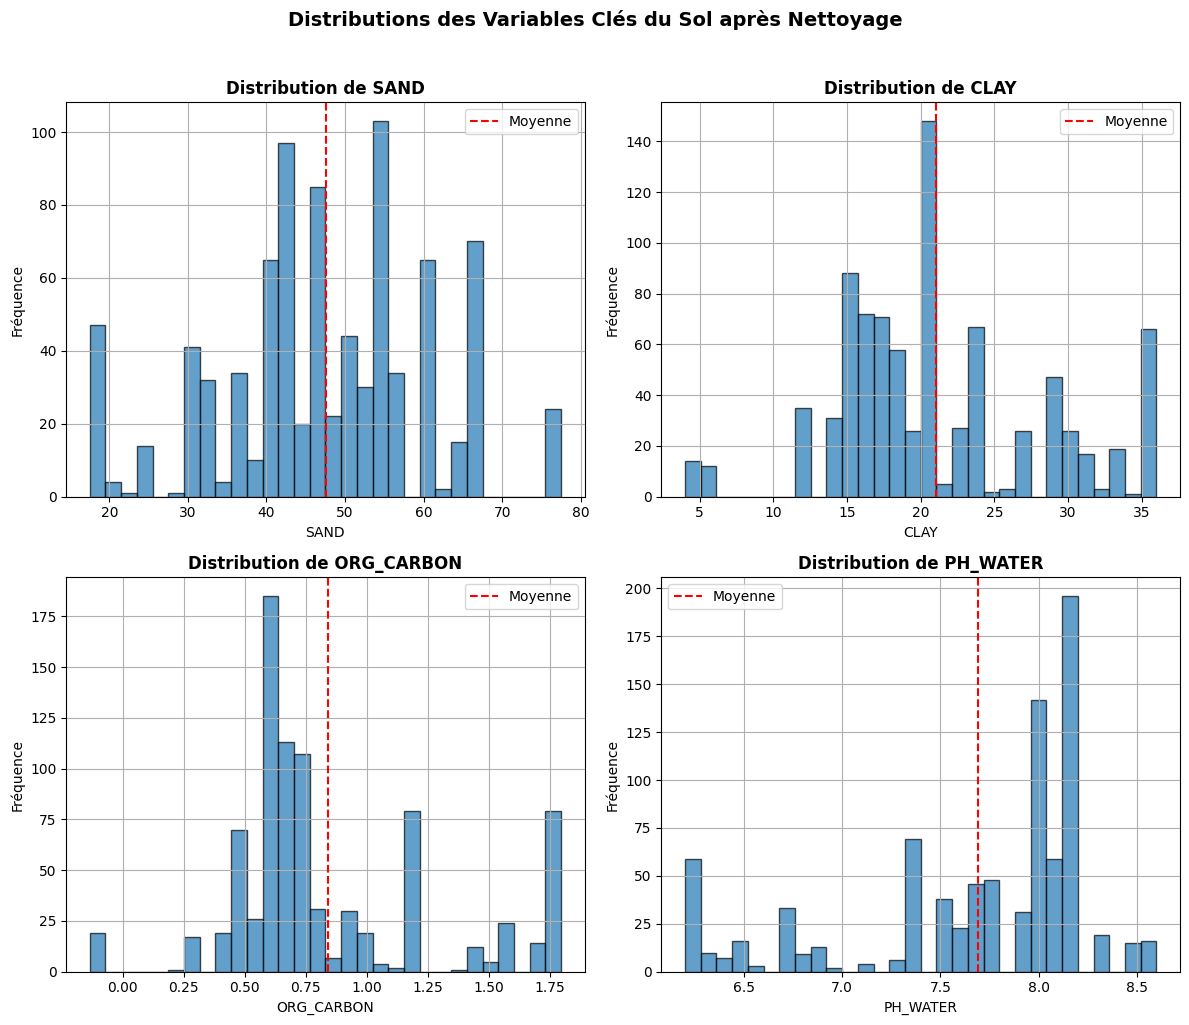


RÉSUMÉ FINAL DU NETTOYAGE

📊 RÉSULTATS :

Dimensions initiales : (864, 24)
Dimensions finales   : (864, 24)
Réduction           : 0 lignes, 
                     0 colonnes

🎯 ACTIONS EFFECTUÉES :

1. Nettoyage de base :
   • 0 doublons supprimés
   • 2 colonnes avec imputation

2. Traitement des outliers :
   • 21 variables avec outliers traités

3. Transformations :
   • Encodage des variables catégorielles

4. Réduction dimensionnelle :
   • 3 colonnes supprimées

📁 FICHIERS GÉNÉRÉS :

• C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv : Dataset nettoyé
• C:\Users\DELL\Desktop\project_fire\data\processed\soil\cleaning_report.txt : Rapport de nettoyage

• C:\Users\DELL\Desktop\project_fire\reports\figures\soil_distributions.png : Visualisations

✅ NETTOYAGE TERMINÉ AVEC SUCCÈS !



In [1]:
# ============================================================================
# DATA CLEANING & PREPROCESSING - DATASET SOL (SANS CRÉATION DE VARIABLES)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================

soil_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_Algeria_Tunisia.csv"
soil_D1 = pd.read_csv(soil_path)

print("="*60)
print("DATASET SOL - ALGÉRIE ET TUNISIE")
print("="*60)
print(f"Dimensions initiales : {soil_D1.shape}")
print(f"Nombre de colonnes : {len(soil_D1.columns)}")
print(f"Nombre d'observations : {len(soil_D1)}")

# ============================================================================
# 2. ANALYSE EXPLORATOIRE APPROFONDIE
# ============================================================================

print("\n" + "="*60)
print("ANALYSE EXPLORATOIRE")
print("="*60)

# 2.1 Types de données
print("\n1. Types de données :")
print(soil_D1.dtypes)

# 2.2 Valeurs manquantes
print("\n2. Valeurs manquantes par colonne :")
missing_values = soil_D1.isna().sum()
missing_percent = (missing_values / len(soil_D1)) * 100

missing_df = pd.DataFrame({
    'Valeurs_manquantes': missing_values,
    'Pourcentage': missing_percent
}).sort_values('Pourcentage', ascending=False)

# Afficher seulement les colonnes avec des valeurs manquantes
print(missing_df[missing_df['Valeurs_manquantes'] > 0])

# 2.3 Statistiques descriptives
print("\n3. Statistiques descriptives (colonnes numériques) :")
numeric_cols = soil_D1.select_dtypes(include=[np.number]).columns.tolist()
print(soil_D1[numeric_cols].describe().transpose())

# 2.4 Valeurs uniques
print("\n4. Nombre de valeurs uniques :")
for col in soil_D1.columns:
    unique_count = soil_D1[col].nunique()
    print(f"  {col:20} : {unique_count:4} valeurs uniques")

# ============================================================================
# 3. NETTOYAGE DES DONNÉES
# ============================================================================

print("\n" + "="*60)
print("NETTOYAGE DES DONNÉES")
print("="*60)

# Copie pour les modifications
soil_clean = soil_D1.copy()

# 3.1 Suppression des doublons
initial_rows = len(soil_clean)
soil_clean = soil_clean.drop_duplicates()
duplicates_removed = initial_rows - len(soil_clean)
print(f"1. Doublons supprimés : {duplicates_removed}")

# 3.2 Traitement des valeurs manquantes
print("\n2. Traitement des valeurs manquantes :")

# Stratégie différenciée selon les colonnes
missing_strategy = {}

# Colonnes avec peu de NaN (<5%) : imputation par moyenne/médiane
for col in ['TEXTURE_USDA', 'REF_BULK']:
    if col in soil_clean.columns and soil_clean[col].isna().sum() > 0:
        missing_count = soil_clean[col].isna().sum()
        missing_pct = (missing_count / len(soil_clean)) * 100
        
        # Pour les variables continues, utiliser la médiane (plus robuste)
        if soil_clean[col].dtype in ['float64', 'int64']:
            impute_value = soil_clean[col].median()
            strategy = f"médiane ({impute_value:.2f})"
        else:
            impute_value = soil_clean[col].mode()[0] if not soil_clean[col].mode().empty else None
            strategy = f"mode ({impute_value})"
        
        soil_clean[col] = soil_clean[col].fillna(impute_value)
        missing_strategy[col] = strategy
        
        print(f"  • {col:15} : {missing_count:3} NaN ({missing_pct:.1f}%) → Imputation par {strategy}")

print(f"\n  Total NaN traités : {soil_clean.isna().sum().sum()}")

# 3.3 Vérification des incohérences
print("\n3. Vérification des incohérences :")

# Vérifier que SAND + SILT + CLAY ≈ 100% (pour la texture du sol)
if all(col in soil_clean.columns for col in ['SAND', 'SILT', 'CLAY']):
    soil_clean['TEXTURE_SUM'] = soil_clean['SAND'] + soil_clean['SILT'] + soil_clean['CLAY']
    
    # Identifier les incohérences
    texture_inconsistencies = soil_clean[(soil_clean['TEXTURE_SUM'] < 95) | (soil_clean['TEXTURE_SUM'] > 105)]
    
    if len(texture_inconsistencies) > 0:
        print(f"  ⚠️  {len(texture_inconsistencies)} incohérences détectées (SAND+SILT+CLAY ≠ 100%)")
        print(f"     Moyenne : {soil_clean['TEXTURE_SUM'].mean():.1f}%")
        print(f"     Min : {soil_clean['TEXTURE_SUM'].min():.1f}%")
        print(f"     Max : {soil_clean['TEXTURE_SUM'].max():.1f}%")
        
        # Normaliser pour que la somme fasse 100%
        soil_clean['SAND'] = (soil_clean['SAND'] / soil_clean['TEXTURE_SUM']) * 100
        soil_clean['SILT'] = (soil_clean['SILT'] / soil_clean['TEXTURE_SUM']) * 100
        soil_clean['CLAY'] = (soil_clean['CLAY'] / soil_clean['TEXTURE_SUM']) * 100
        
        soil_clean['TEXTURE_SUM'] = soil_clean['SAND'] + soil_clean['SILT'] + soil_clean['CLAY']
        print(f"  ✅ Texture normalisée (moyenne après correction : {soil_clean['TEXTURE_SUM'].mean():.1f}%)")
    
    # Supprimer la colonne temporaire
    soil_clean = soil_clean.drop(columns=['TEXTURE_SUM'])

# ============================================================================
# 4. DÉTECTION ET TRAITEMENT DES OUTLIERS
# ============================================================================

print("\n" + "="*60)
print("DÉTECTION DES OUTLIERS")
print("="*60)

# 4.1 Méthode IQR pour détecter les outliers
outliers_info = {}

for col in numeric_cols:
    if col not in ['HWSD2_SMU_ID']:  # Exclure les ID
        Q1 = soil_clean[col].quantile(0.25)
        Q3 = soil_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = soil_clean[(soil_clean[col] < lower_bound) | (soil_clean[col] > upper_bound)]
        outliers_count = len(outliers)
        
        if outliers_count > 0:
            outliers_percent = (outliers_count / len(soil_clean)) * 100
            outliers_info[col] = {
                'count': outliers_count,
                'percent': outliers_percent,
                'lower': lower_bound,
                'upper': upper_bound,
                'min': soil_clean[col].min(),
                'max': soil_clean[col].max()
            }

# Afficher les colonnes avec outliers
if outliers_info:
    print("Colonnes avec des outliers détectés :")
    for col, info in sorted(outliers_info.items(), key=lambda x: x[1]['percent'], reverse=True):
        print(f"  • {col:15} : {info['count']:3} outliers ({info['percent']:.1f}%)")
else:
    print("Aucun outlier détecté avec la méthode IQR.")

# 4.2 Traitement des outliers (winsorizing)
print("\nTraitement des outliers (winsorizing) :")

for col, info in outliers_info.items():
    if info['percent'] < 10:  # Seulement si moins de 10% d'outliers
        # Winsorizing : remplacer les outliers par les bornes
        soil_clean[col] = np.where(soil_clean[col] < info['lower'], info['lower'],
                                  np.where(soil_clean[col] > info['upper'], info['upper'],
                                          soil_clean[col]))
        
        outliers_after = len(soil_clean[(soil_clean[col] < info['lower']) | (soil_clean[col] > info['upper'])])
        print(f"  • {col:15} : {info['count']:3} → {outliers_after:3} outliers après traitement")

# ============================================================================
# 5. TRANSFORMATION DES VARIABLES EXISTANTES
# ============================================================================

print("\n" + "="*60)
print("TRANSFORMATION DES VARIABLES EXISTANTES")
print("="*60)

# 5.1 Encodage des variables catégorielles
categorical_cols = soil_clean.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    print("1. Encodage des variables catégorielles :")
    
    # Pour LAYER : label encoding simple (car 1 seule valeur)
    if 'LAYER' in categorical_cols:
        unique_layers = soil_clean['LAYER'].unique()
        if len(unique_layers) == 1:
            print(f"  • LAYER : 1 seule valeur ('{unique_layers[0]}') → Suppression")
            soil_clean = soil_clean.drop(columns=['LAYER'])
        else:
            layer_mapping = {layer: idx for idx, layer in enumerate(unique_layers)}
            soil_clean['LAYER_ENCODED'] = soil_clean['LAYER'].map(layer_mapping)
            print(f"  • LAYER : {len(unique_layers)} valeurs → Label encoding")
    
    # Pour TEXTURE_SOTER : one-hot encoding si peu de catégories
    if 'TEXTURE_SOTER' in categorical_cols:
        unique_textures = soil_clean['TEXTURE_SOTER'].unique()
        if len(unique_textures) <= 10:  # One-hot pour ≤ 10 catégories
            texture_dummies = pd.get_dummies(soil_clean['TEXTURE_SOTER'], prefix='TEXTURE')
            soil_clean = pd.concat([soil_clean, texture_dummies], axis=1)
            print(f"  • TEXTURE_SOTER : {len(unique_textures)} valeurs → One-hot encoding")
        else:
            texture_mapping = {texture: idx for idx, texture in enumerate(unique_textures)}
            soil_clean['TEXTURE_SOTER_ENCODED'] = soil_clean['TEXTURE_SOTER'].map(texture_mapping)
            print(f"  • TEXTURE_SOTER : {len(unique_textures)} valeurs → Label encoding")
else:
    print("Aucune variable catégorielle à encoder.")

# ============================================================================
# 6. RÉDUCTION DE DIMENSIONNALITÉ
# ============================================================================

print("\n" + "="*60)
print("RÉDUCTION DE DIMENSIONNALITÉ")
print("="*60)

# 6.1 Suppression des colonnes peu informatives
cols_to_drop = []

# ID unique
if 'HWSD2_SMU_ID' in soil_clean.columns:
    cols_to_drop.append('HWSD2_SMU_ID')
    print("1. Colonnes supprimées :")
    print(f"  • HWSD2_SMU_ID : Identifiant unique")

# Variables redondantes
if 'TEXTURE_USDA' in soil_clean.columns and 'TEXTURE_SOTER' in soil_clean.columns:
    # Garder TEXTURE_SOTER (plus standard)
    cols_to_drop.append('TEXTURE_USDA')
    print(f"  • TEXTURE_USDA : Redondant avec TEXTURE_SOTER")

if 'REF_BULK' in soil_clean.columns and 'BULK' in soil_clean.columns:
    # Garder BULK (valeur mesurée)
    cols_to_drop.append('REF_BULK')
    print(f"  • REF_BULK : Redondant avec BULK")

# Variables catégorielles originales (après encodage)
for col in ['LAYER', 'TEXTURE_SOTER']:
    if col in soil_clean.columns and f'{col}_ENCODED' in soil_clean.columns:
        cols_to_drop.append(col)
        print(f"  • {col} : Version originale après encodage")

# Appliquer les suppressions
if cols_to_drop:
    soil_clean = soil_clean.drop(columns=cols_to_drop)
    print(f"\n  Total colonnes supprimées : {len(cols_to_drop)}")

# 6.2 Analyse de corrélation pour détecter la multicolinéarité
print("\n2. Analyse de corrélation :")

# Calculer la matrice de corrélation
numeric_cols_clean = soil_clean.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols_clean) > 1:
    corr_matrix = soil_clean[numeric_cols_clean].corr().abs()
    
    # Identifier les paires fortement corrélées (>0.9)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.9:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("  Paires fortement corrélées (ρ > 0.9) :")
        for col1, col2, corr_value in high_corr_pairs[:5]:  # Afficher les 5 premières
            print(f"    • {col1:20} ↔ {col2:20} : {corr_value:.3f}")
        
        # Suggestion de suppression
        cols_to_consider = []
        for col1, col2, _ in high_corr_pairs:
            # Garder la variable avec moins de valeurs manquantes ou plus d'information
            if col1 in soil_clean.columns and col2 in soil_clean.columns:
                if soil_clean[col1].nunique() < soil_clean[col2].nunique():
                    cols_to_consider.append(col1)
                else:
                    cols_to_consider.append(col2)
        
        if cols_to_consider:
            print(f"\n  Suggestions de suppression pour réduire la multicolinéarité :")
            for col in set(cols_to_consider):
                print(f"    • {col}")
    else:
        print("  Aucune forte corrélation détectée (ρ < 0.9)")
else:
    print("  Pas assez de variables numériques pour l'analyse de corrélation.")

# ============================================================================
# 7. CONTRÔLE DE QUALITÉ FINAL
# ============================================================================

print("\n" + "="*60)
print("CONTRÔLE DE QUALITÉ FINAL")
print("="*60)

# 7.1 Vérifications finales
print("1. Vérifications :")
print(f"  • Valeurs manquantes restantes : {soil_clean.isna().sum().sum()}")
print(f"  • Dimensions finales : {soil_clean.shape}")
print(f"  • Types de données :")
print(f"      - Numériques : {len(soil_clean.select_dtypes(include=[np.number]).columns)}")
print(f"      - Catégorielles : {len(soil_clean.select_dtypes(include=['object']).columns)}")

# 7.2 Statistiques descriptives finales
print("\n2. Statistiques descriptives finales (échantillon) :")
final_numeric_cols = soil_clean.select_dtypes(include=[np.number]).columns.tolist()[:5]  # 5 premières
if final_numeric_cols:
    print(soil_clean[final_numeric_cols].describe().transpose()[['mean', 'std', 'min', 'max']])
else:
    print("Aucune variable numérique disponible.")

# ============================================================================
# 8. SAUVEGARDE
# ============================================================================

print("\n" + "="*60)
print("SAUVEGARDE DES DONNÉES NETTOYÉES")
print("="*60)

# Sauvegarder le dataset nettoyé
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
soil_clean.to_csv(output_path, index=False)

print(f"Dataset sauvegardé : {output_path}")
print(f"Taille finale : {soil_clean.shape}")

# Sauvegarder un rapport de nettoyage
report_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\cleaning_report.txt"
with open(report_path, 'w') as f:
    f.write("RAPPORT DE NETTOYAGE - DATASET SOL\n")
    f.write("="*50 + "\n\n")
    f.write(f"Date : {pd.Timestamp.now()}\n")
    f.write(f"Fichier source : {soil_path}\n\n")
    
    f.write("1. STATISTIQUES INITIALES\n")
    f.write("-"*30 + "\n")
    f.write(f"Dimensions initiales : {soil_D1.shape}\n")
    f.write(f"Valeurs manquantes initiales : {soil_D1.isna().sum().sum()}\n\n")
    
    f.write("2. ACTIONS APPLIQUÉES\n")
    f.write("-"*30 + "\n")
    f.write(f"Doublons supprimés : {duplicates_removed}\n")
    f.write(f"Colonnes supprimées : {len(cols_to_drop)}\n")
    f.write(f"Outliers traités : {len(outliers_info)}\n\n")
    
    f.write("3. RÉSULTATS FINAUX\n")
    f.write("-"*30 + "\n")
    f.write(f"Dimensions finales : {soil_clean.shape}\n")
    f.write(f"Valeurs manquantes finales : {soil_clean.isna().sum().sum()}\n")
    f.write(f"Colonnes finales : {len(soil_clean.columns)}\n")
    
    if missing_strategy:
        f.write("\n4. STRATÉGIES D'IMPUTATION\n")
        f.write("-"*30 + "\n")
        for col, strategy in missing_strategy.items():
            f.write(f"{col:20} : {strategy}\n")

print(f"Rapport de nettoyage sauvegardé : {report_path}")

# ============================================================================
# 9. VISUALISATION DES RÉSULTATS
# ============================================================================

print("\n" + "="*60)
print("VISUALISATION DES RÉSULTATS")
print("="*60)

# Créer quelques visualisations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution des variables clés
key_vars = ['SAND', 'CLAY', 'ORG_CARBON', 'PH_WATER']
available_key_vars = [var for var in key_vars if var in soil_clean.columns]

if available_key_vars:
    for idx, var in enumerate(available_key_vars[:4]):  # Maximum 4 graphiques
        ax = axes[idx//2, idx%2]
        soil_clean[var].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution de {var}', fontweight='bold')
        ax.set_xlabel(var)
        ax.set_ylabel('Fréquence')
        ax.axvline(soil_clean[var].mean(), color='red', linestyle='--', label='Moyenne')
        ax.legend()
    
    # Cacher les axes inutilisés
    for idx in range(len(available_key_vars), 4):
        fig.delaxes(axes[idx//2, idx%2])
    
    plt.suptitle('Distributions des Variables Clés du Sol après Nettoyage', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Sauvegarder la figure
    figure_path = r"C:\Users\DELL\Desktop\project_fire\reports\figures\soil_distributions.png"
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"Figure sauvegardée : {figure_path}")
    plt.show()
else:
    print("Aucune variable clé disponible pour la visualisation.")

# ============================================================================
# 10. RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*60)
print("RÉSUMÉ FINAL DU NETTOYAGE")
print("="*60)

print(f"""
📊 RÉSULTATS :

Dimensions initiales : {soil_D1.shape}
Dimensions finales   : {soil_clean.shape}
Réduction           : {soil_D1.shape[0] - soil_clean.shape[0]} lignes, 
                     {soil_D1.shape[1] - soil_clean.shape[1]} colonnes

🎯 ACTIONS EFFECTUÉES :

1. Nettoyage de base :
   • {duplicates_removed} doublons supprimés
   • {len(missing_strategy)} colonnes avec imputation

2. Traitement des outliers :
   • {len(outliers_info)} variables avec outliers traités

3. Transformations :
   • Encodage des variables catégorielles

4. Réduction dimensionnelle :
   • {len(cols_to_drop)} colonnes supprimées

📁 FICHIERS GÉNÉRÉS :

• {output_path} : Dataset nettoyé
• {report_path} : Rapport de nettoyage
""")

if available_key_vars:
    print(f"• {figure_path} : Visualisations")

print("""
✅ NETTOYAGE TERMINÉ AVEC SUCCÈS !
""")

DATASET SOL - ALGÉRIE ET TUNISIE
Dimensions initiales : (864, 24)
Nombre de colonnes : 24
Nombre d'observations : 864

ANALYSE EXPLORATOIRE

1. Types de données :
HWSD2_SMU_ID       int64
LAYER             object
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object

2. Valeurs manquantes par colonne :
              Valeurs_manquantes  Pourcentage
TEXTURE_USDA                  19     2.199074
REF_BULK                      19     2.199074

3. Statistiques descriptives (colonnes numériqu

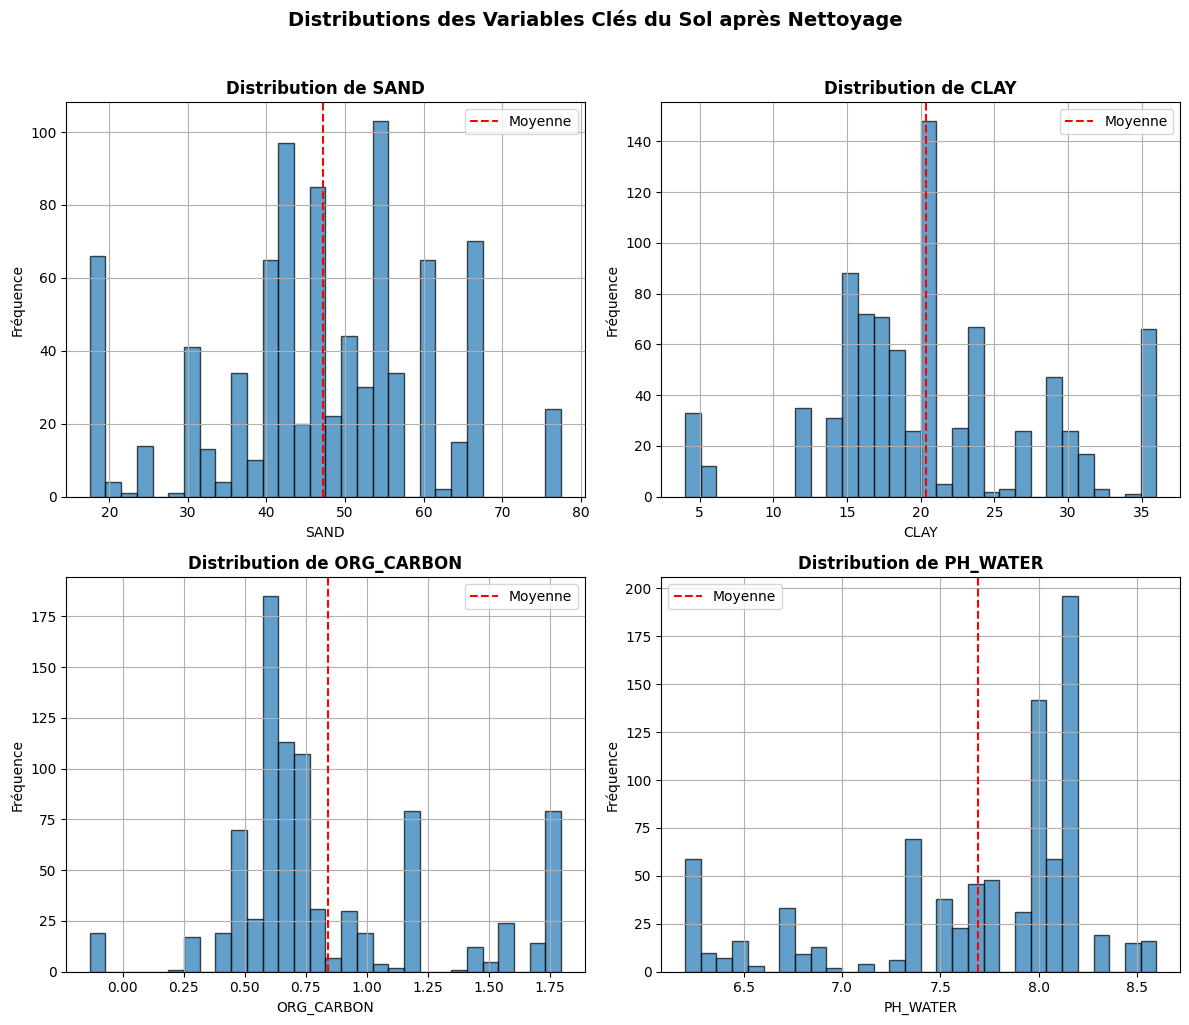


RÉSUMÉ FINAL DU NETTOYAGE

📊 RÉSULTATS :

Dimensions initiales : (864, 24)
Dimensions finales   : (864, 24)
Réduction           : 0 lignes, 
                     0 colonnes

🎯 ACTIONS EFFECTUÉES :

1. Nettoyage de base :
   • 0 doublons supprimés
   • 2 colonnes avec imputation

2. Traitement des outliers :
   • 21 variables avec outliers traités

3. Transformations :
   • Encodage des variables catégorielles

4. Réduction dimensionnelle :
   • 3 colonnes supprimées

📁 FICHIERS GÉNÉRÉS :

• C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv : Dataset nettoyé
• C:\Users\DELL\Desktop\project_fire\data\processed\soil\cleaning_report.txt : Rapport de nettoyage

• C:\Users\DELL\Desktop\project_fire\reports\figures\soil_distributions.png : Visualisations

✅ NETTOYAGE TERMINÉ AVEC SUCCÈS !



In [ ]:
# ============================================================================
# DATA CLEANING & PREPROCESSING - DATASET SOL (SANS CRÉATION DE VARIABLES)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CHARGEMENT DES DONNÉES
# ============================================================================

soil_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_Algeria_Tunisia.csv"
soil_D1 = pd.read_csv(soil_path)

print("="*60)
print("DATASET SOL - ALGÉRIE ET TUNISIE")
print("="*60)
print(f"Dimensions initiales : {soil_D1.shape}")
print(f"Nombre de colonnes : {len(soil_D1.columns)}")
print(f"Nombre d'observations : {len(soil_D1)}")

# ============================================================================
# 2. ANALYSE EXPLORATOIRE APPROFONDIE
# ============================================================================

print("\n" + "="*60)
print("ANALYSE EXPLORATOIRE")
print("="*60)

# 2.1 Types de données
print("\n1. Types de données :")
print(soil_D1.dtypes)

# 2.2 Valeurs manquantes
print("\n2. Valeurs manquantes par colonne :")
missing_values = soil_D1.isna().sum()
missing_percent = (missing_values / len(soil_D1)) * 100

missing_df = pd.DataFrame({
    'Valeurs_manquantes': missing_values,
    'Pourcentage': missing_percent
}).sort_values('Pourcentage', ascending=False)

# Afficher seulement les colonnes avec des valeurs manquantes
print(missing_df[missing_df['Valeurs_manquantes'] > 0])

# 2.3 Statistiques descriptives
print("\n3. Statistiques descriptives (colonnes numériques) :")
numeric_cols = soil_D1.select_dtypes(include=[np.number]).columns.tolist()
print(soil_D1[numeric_cols].describe().transpose())

# 2.4 Valeurs uniques
print("\n4. Nombre de valeurs uniques :")
for col in soil_D1.columns:
    unique_count = soil_D1[col].nunique()
    print(f"  {col:20} : {unique_count:4} valeurs uniques")

# ============================================================================
# 3. NETTOYAGE DES DONNÉES
# ============================================================================

print("\n" + "="*60)
print("NETTOYAGE DES DONNÉES")
print("="*60)

# Copie pour les modifications
soil_clean = soil_D1.copy()

# 3.1 Suppression des doublons
initial_rows = len(soil_clean)
soil_clean = soil_clean.drop_duplicates()
duplicates_removed = initial_rows - len(soil_clean)
print(f"1. Doublons supprimés : {duplicates_removed}")

# 3.2 Traitement des valeurs manquantes
print("\n2. Traitement des valeurs manquantes :")

# Stratégie différenciée selon les colonnes
missing_strategy = {}

# Colonnes avec peu de NaN (<5%) : imputation par moyenne/médiane
for col in ['TEXTURE_USDA', 'REF_BULK']:
    if col in soil_clean.columns and soil_clean[col].isna().sum() > 0:
        missing_count = soil_clean[col].isna().sum()
        missing_pct = (missing_count / len(soil_clean)) * 100
        
        # Pour les variables continues, utiliser la médiane (plus robuste)
        if soil_clean[col].dtype in ['float64', 'int64']:
            impute_value = soil_clean[col].median()
            strategy = f"médiane ({impute_value:.2f})"
        else:
            impute_value = soil_clean[col].mode()[0] if not soil_clean[col].mode().empty else None
            strategy = f"mode ({impute_value})"
        
        soil_clean[col] = soil_clean[col].fillna(impute_value)
        missing_strategy[col] = strategy
        
        print(f"  • {col:15} : {missing_count:3} NaN ({missing_pct:.1f}%) → Imputation par {strategy}")

print(f"\n  Total NaN traités : {soil_clean.isna().sum().sum()}")

# 3.3 Vérification des incohérences (SANS NORMALISATION)
print("\n3. Vérification des incohérences :")

# Vérifier que SAND + SILT + CLAY ≈ 100% (pour la texture du sol)
if all(col in soil_clean.columns for col in ['SAND', 'SILT', 'CLAY']):
    soil_clean['TEXTURE_SUM'] = soil_clean['SAND'] + soil_clean['SILT'] + soil_clean['CLAY']
    
    # Identifier les incohérences
    texture_inconsistencies = soil_clean[(soil_clean['TEXTURE_SUM'] < 95) | (soil_clean['TEXTURE_SUM'] > 105)]
    
    if len(texture_inconsistencies) > 0:
        print(f"  ⚠️  {len(texture_inconsistencies)} incohérences détectées (SAND+SILT+CLAY ≠ 100%)")
        print(f"     Moyenne : {soil_clean['TEXTURE_SUM'].mean():.1f}%")
        print(f"     Min : {soil_clean['TEXTURE_SUM'].min():.1f}%")
        print(f"     Max : {soil_clean['TEXTURE_SUM'].max():.1f}%")
        
        # ✅ PAS DE NORMALISATION - juste identification
        print(f"  ⏭️  Incohérences identifiées mais PAS corrigées (conservation des données originales)")
    
    # Supprimer la colonne temporaire
    soil_clean = soil_clean.drop(columns=['TEXTURE_SUM'])

# ============================================================================
# 4. DÉTECTION ET TRAITEMENT DES OUTLIERS
# ============================================================================

print("\n" + "="*60)
print("DÉTECTION DES OUTLIERS")
print("="*60)

# 4.1 Méthode IQR pour détecter les outliers
outliers_info = {}

for col in numeric_cols:
    if col not in ['HWSD2_SMU_ID']:  # Exclure les ID
        Q1 = soil_clean[col].quantile(0.25)
        Q3 = soil_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = soil_clean[(soil_clean[col] < lower_bound) | (soil_clean[col] > upper_bound)]
        outliers_count = len(outliers)
        
        if outliers_count > 0:
            outliers_percent = (outliers_count / len(soil_clean)) * 100
            outliers_info[col] = {
                'count': outliers_count,
                'percent': outliers_percent,
                'lower': lower_bound,
                'upper': upper_bound,
                'min': soil_clean[col].min(),
                'max': soil_clean[col].max()
            }

# Afficher les colonnes avec outliers
if outliers_info:
    print("Colonnes avec des outliers détectés :")
    for col, info in sorted(outliers_info.items(), key=lambda x: x[1]['percent'], reverse=True):
        print(f"  • {col:15} : {info['count']:3} outliers ({info['percent']:.1f}%)")
else:
    print("Aucun outlier détecté avec la méthode IQR.")

# 4.2 Traitement des outliers (winsorizing)
print("\nTraitement des outliers (winsorizing) :")

for col, info in outliers_info.items():
    if info['percent'] < 10:  # Seulement si moins de 10% d'outliers
        # Winsorizing : remplacer les outliers par les bornes
        soil_clean[col] = np.where(soil_clean[col] < info['lower'], info['lower'],
                                  np.where(soil_clean[col] > info['upper'], info['upper'],
                                          soil_clean[col]))
        
        outliers_after = len(soil_clean[(soil_clean[col] < info['lower']) | (soil_clean[col] > info['upper'])])
        print(f"  • {col:15} : {info['count']:3} → {outliers_after:3} outliers après traitement")

# ============================================================================
# 5. TRANSFORMATION DES VARIABLES EXISTANTES
# ============================================================================

print("\n" + "="*60)
print("TRANSFORMATION DES VARIABLES EXISTANTES")
print("="*60)

# 5.1 Encodage des variables catégorielles
categorical_cols = soil_clean.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    print("1. Encodage des variables catégorielles :")
    
    # Pour LAYER : label encoding simple (car 1 seule valeur)
    if 'LAYER' in categorical_cols:
        unique_layers = soil_clean['LAYER'].unique()
        if len(unique_layers) == 1:
            print(f"  • LAYER : 1 seule valeur ('{unique_layers[0]}') → Suppression")
            soil_clean = soil_clean.drop(columns=['LAYER'])
        else:
            layer_mapping = {layer: idx for idx, layer in enumerate(unique_layers)}
            soil_clean['LAYER_ENCODED'] = soil_clean['LAYER'].map(layer_mapping)
            print(f"  • LAYER : {len(unique_layers)} valeurs → Label encoding")
    
    # Pour TEXTURE_SOTER : one-hot encoding si peu de catégories
    if 'TEXTURE_SOTER' in categorical_cols:
        unique_textures = soil_clean['TEXTURE_SOTER'].unique()
        if len(unique_textures) <= 10:  # One-hot pour ≤ 10 catégories
            texture_dummies = pd.get_dummies(soil_clean['TEXTURE_SOTER'], prefix='TEXTURE')
            soil_clean = pd.concat([soil_clean, texture_dummies], axis=1)
            print(f"  • TEXTURE_SOTER : {len(unique_textures)} valeurs → One-hot encoding")
        else:
            texture_mapping = {texture: idx for idx, texture in enumerate(unique_textures)}
            soil_clean['TEXTURE_SOTER_ENCODED'] = soil_clean['TEXTURE_SOTER'].map(texture_mapping)
            print(f"  • TEXTURE_SOTER : {len(unique_textures)} valeurs → Label encoding")
else:
    print("Aucune variable catégorielle à encoder.")

# ============================================================================
# 6. RÉDUCTION DE DIMENSIONNALITÉ
# ============================================================================

print("\n" + "="*60)
print("RÉDUCTION DE DIMENSIONNALITÉ")
print("="*60)

# Variables catégorielles originales (après encodage)
for col in ['LAYER', 'TEXTURE_SOTER']:
    if col in soil_clean.columns and f'{col}_ENCODED' in soil_clean.columns:
        cols_to_drop.append(col)
        print(f"  • {col} : Version originale après encodage")

# 6.2 Analyse de corrélation pour détecter la multicolinéarité
print("\n2. Analyse de corrélation :")

# Calculer la matrice de corrélation
numeric_cols_clean = soil_clean.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols_clean) > 1:
    corr_matrix = soil_clean[numeric_cols_clean].corr().abs()
    
    # Identifier les paires fortement corrélées (>0.9)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.9:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("  Paires fortement corrélées (ρ > 0.9) :")
        for col1, col2, corr_value in high_corr_pairs[:5]:  # Afficher les 5 premières
            print(f"    • {col1:20} ↔ {col2:20} : {corr_value:.3f}")
    

# ============================================================================
# 7. CONTRÔLE DE QUALITÉ FINAL
# ============================================================================

print("\n" + "="*60)
print("CONTRÔLE DE QUALITÉ FINAL")
print("="*60)

# 7.1 Vérifications finales
print("1. Vérifications :")
print(f"  • Valeurs manquantes restantes : {soil_clean.isna().sum().sum()}")
print(f"  • Dimensions finales : {soil_clean.shape}")
print(f"  • Types de données :")
print(f"      - Numériques : {len(soil_clean.select_dtypes(include=[np.number]).columns)}")
print(f"      - Catégorielles : {len(soil_clean.select_dtypes(include=['object']).columns)}")

# 7.2 Statistiques descriptives finales
print("\n2. Statistiques descriptives finales (échantillon) :")
final_numeric_cols = soil_clean.select_dtypes(include=[np.number]).columns.tolist()[:5]  # 5 premières
if final_numeric_cols:
    print(soil_clean[final_numeric_cols].describe().transpose()[['mean', 'std', 'min', 'max']])
else:
    print("Aucune variable numérique disponible.")

# ============================================================================
# 8. SAUVEGARDE
# ============================================================================

print("\n" + "="*60)
print("SAUVEGARDE DES DONNÉES NETTOYÉES")
print("="*60)

# Sauvegarder le dataset nettoyé
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
soil_clean.to_csv(output_path, index=False)

print(f"Dataset sauvegardé : {output_path}")
print(f"Taille finale : {soil_clean.shape}")

# Sauvegarder un rapport de nettoyage
report_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\cleaning_report.txt"
with open(report_path, 'w') as f:
    f.write("RAPPORT DE NETTOYAGE - DATASET SOL\n")
    f.write("="*50 + "\n\n")
    f.write(f"Date : {pd.Timestamp.now()}\n")
    f.write(f"Fichier source : {soil_path}\n\n")
    
    f.write("1. STATISTIQUES INITIALES\n")
    f.write("-"*30 + "\n")
    f.write(f"Dimensions initiales : {soil_D1.shape}\n")
    f.write(f"Valeurs manquantes initiales : {soil_D1.isna().sum().sum()}\n\n")
    
    f.write("2. ACTIONS APPLIQUÉES\n")
    f.write("-"*30 + "\n")
    f.write(f"Doublons supprimés : {duplicates_removed}\n")
    f.write(f"Colonnes supprimées : {len(cols_to_drop)}\n")
    f.write(f"Outliers traités : {len(outliers_info)}\n\n")
    
    f.write("3. RÉSULTATS FINAUX\n")
    f.write("-"*30 + "\n")
    f.write(f"Dimensions finales : {soil_clean.shape}\n")
    f.write(f"Valeurs manquantes finales : {soil_clean.isna().sum().sum()}\n")
    f.write(f"Colonnes finales : {len(soil_clean.columns)}\n")
    
    if missing_strategy:
        f.write("\n4. STRATÉGIES D'IMPUTATION\n")
        f.write("-"*30 + "\n")
        for col, strategy in missing_strategy.items():
            f.write(f"{col:20} : {strategy}\n")

print(f"Rapport de nettoyage sauvegardé : {report_path}")

# ============================================================================
# 9. VISUALISATION DES RÉSULTATS
# ============================================================================

print("\n" + "="*60)
print("VISUALISATION DES RÉSULTATS")
print("="*60)

# Créer quelques visualisations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Distribution des variables clés
key_vars = ['SAND', 'CLAY', 'ORG_CARBON', 'PH_WATER']
available_key_vars = [var for var in key_vars if var in soil_clean.columns]

if available_key_vars:
    for idx, var in enumerate(available_key_vars[:4]):  # Maximum 4 graphiques
        ax = axes[idx//2, idx%2]
        soil_clean[var].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution de {var}', fontweight='bold')
        ax.set_xlabel(var)
        ax.set_ylabel('Fréquence')
        ax.axvline(soil_clean[var].mean(), color='red', linestyle='--', label='Moyenne')
        ax.legend()
    
    # Cacher les axes inutilisés
    for idx in range(len(available_key_vars), 4):
        fig.delaxes(axes[idx//2, idx%2])
    
    plt.suptitle('Distributions des Variables Clés du Sol après Nettoyage', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Sauvegarder la figure
    figure_path = r"C:\Users\DELL\Desktop\project_fire\reports\figures\soil_distributions.png"
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"Figure sauvegardée : {figure_path}")
    plt.show()
else:
    print("Aucune variable clé disponible pour la visualisation.")

# ============================================================================
# 10. RÉSUMÉ FINAL
# ============================================================================

print("\n" + "="*60)
print("RÉSUMÉ FINAL DU NETTOYAGE")
print("="*60)

print(f"""
📊 RÉSULTATS :

Dimensions initiales : {soil_D1.shape}
Dimensions finales   : {soil_clean.shape}
Réduction           : {soil_D1.shape[0] - soil_clean.shape[0]} lignes, 
                     {soil_D1.shape[1] - soil_clean.shape[1]} colonnes

🎯 ACTIONS EFFECTUÉES :

1. Nettoyage de base :
   • {duplicates_removed} doublons supprimés
   • {len(missing_strategy)} colonnes avec imputation

2. Traitement des outliers :
   • {len(outliers_info)} variables avec outliers traités

3. Transformations :
   • Encodage des variables catégorielles

4. Réduction dimensionnelle :
   • {len(cols_to_drop)} colonnes supprimées

📁 FICHIERS GÉNÉRÉS :

• {output_path} : Dataset nettoyé
• {report_path} : Rapport de nettoyage
""")

if available_key_vars:
    print(f"• {figure_path} : Visualisations")

print("""
✅ NETTOYAGE TERMINÉ AVEC SUCCÈS !
""")

In [1]:
# ============================================================================
# CODE ESSENTIEL : SUPPRESSION DES COLONNES FORTEMENT CORRÉLÉES
# ============================================================================

import pandas as pd
import numpy as np

# 1. CHARGER LE DATASET
soil_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
soil_df = pd.read_csv(soil_path)

print(f"Dataset initial : {soil_df.shape}")

# 2. IDENTIFIER LES COLONNES FORTEMENT CORRÉLÉES
def remove_highly_correlated_features(df, threshold=0.9):
    """
    Supprime les colonnes fortement corrélées
    """
    # Matrice de corrélation
    corr_matrix = df.corr().abs()
    
    # Colonnes à supprimer
    cols_to_drop = set()
    
    # Parcourir la matrice de corrélation
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                
                # Décider quelle colonne supprimer
                var_i = df[colname_i].var()
                var_j = df[colname_j].var()
                
                # Supprimer celle avec la plus petite variance
                if var_i < var_j:
                    cols_to_drop.add(colname_i)
                else:
                    cols_to_drop.add(colname_j)
    
    return cols_to_drop

# 3. APPLIQUER LA SUPPRESSION
# Sélectionner uniquement les colonnes numériques
numeric_cols = soil_df.select_dtypes(include=[np.number]).columns.tolist()
soil_numeric = soil_df[numeric_cols]

# Trouver les colonnes à supprimer
cols_to_remove = remove_highly_correlated_features(soil_numeric, threshold=0.9)

print(f"\nColonnes à supprimer (corrélation ≥ 0.9) :")
for col in sorted(cols_to_remove):
    print(f"  • {col}")

# 4. CRÉER LE DATASET RÉDUIT
soil_reduced = soil_df.drop(columns=cols_to_remove)

print(f"\nDataset réduit : {soil_reduced.shape}")
print(f"Colonnes supprimées : {len(cols_to_remove)}")

# 5. SAUVEGARDER
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_reduced.csv"
soil_reduced.to_csv(output_path, index=False)
print(f"\n✅ Dataset sauvegardé : {output_path}")

# 6. VÉRIFICATION RAPIDE
print(f"\nVérification :")
print(f"• Variables conservées : {list(soil_reduced.columns)}")
print(f"• Types de données :")
print(soil_reduced.dtypes.value_counts())

Dataset initial : (864, 24)

Colonnes à supprimer (corrélation ≥ 0.9) :
  • TOTAL_N

Dataset réduit : (864, 23)
Colonnes supprimées : 1

✅ Dataset sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_reduced.csv

Vérification :
• Variables conservées : ['COARSE', 'SAND', 'SILT', 'CLAY', 'TEXTURE_SOTER', 'BULK', 'ORG_CARBON', 'PH_WATER', 'CN_RATIO', 'CEC_SOIL', 'CEC_CLAY', 'CEC_EFF', 'TEB', 'BSAT', 'ALUM_SAT', 'ESP', 'TCARBON_EQ', 'GYPSUM', 'ELEC_COND', 'TEXTURE_-', 'TEXTURE_C', 'TEXTURE_F', 'TEXTURE_M']
• Types de données :
float64    14
int64       4
bool        4
object      1
Name: count, dtype: int64


In [11]:
# ============================================================================
# SUPPRESSION DES VARIABLES FORTEMENT CORRÉLÉES - DATASET SOL
# ============================================================================

import pandas as pd

# Charger les données
soil_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv"
df = pd.read_csv(soil_path)

print(f"Dataset initial : {df.shape}")

# Liste des colonnes à supprimer BASÉE SUR L'ANALYSE DE CORRÉLATION
cols_to_drop = [
    # 1. Relations quasi-parfaites (ρ > 0.95)
    'CEC_EFF',           # ρ=0.99 avec TEB → redondant
    
    # 2. Variables redondantes
    'REF_BULK',          # ρ=0.90 avec SAND, ρ=0.93 avec CLAY → redondant avec BULK
    'TEXTURE_USDA',      # ρ=-0.91 avec CLAY → redondant avec TEXTURE_SOTER
    
    # 3. Fortes corrélations avec variables principales
    'TOTAL_N',           # ρ=0.93 avec ORG_CARBON → souvent dérivé
]

# Vérifier que les colonnes existent avant suppression
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
non_existing = [col for col in cols_to_drop if col not in df.columns]

if non_existing:
    print(f"\n⚠️  Colonnes non trouvées : {non_existing}")

# Appliquer la suppression
df_reduced = df.drop(columns=existing_cols_to_drop)

print(f"\n✅ SUPPRESSION APPLIQUÉE :")
print(f"   • Dataset initial : {df.shape}")
print(f"   • Colonnes supprimées : {len(existing_cols_to_drop)}")
print(f"   • Dataset final : {df_reduced.shape}")

print(f"\n📋 COLONNES SUPPRIMÉES :")
for col in existing_cols_to_drop:
    print(f"   • {col}")

# ============================================================================
# VÉRIFICATION DES CORRÉLATIONS RÉSIDUELLES
# ============================================================================

print(f"\n🔍 VÉRIFICATION DES CORRÉLATIONS RÉSIDUELLES :")

# Calculer les corrélations sur le dataset réduit
numeric_cols = df_reduced.select_dtypes(include=[np.number]).columns
corr_matrix = df_reduced[numeric_cols].corr().abs()

# Identifier les corrélations > 0.8 encore présentes
high_corr_residual = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_residual.append((col1, col2, corr_matrix.iloc[i, j]))

if high_corr_residual:
    print(f"   ⚠️  Corrélations fortes résiduelles (ρ > 0.8) :")
    for col1, col2, corr_value in sorted(high_corr_residual, key=lambda x: x[2], reverse=True):
        print(f"      • {col1:15} ↔ {col2:15} : ρ = {corr_value:.3f}")
else:
    print(f"   ✅ Pas de corrélations fortes résiduelles (ρ ≤ 0.8)")

# ============================================================================
# SAUVEGARDE
# ============================================================================

output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_finalll.csv"
df_reduced.to_csv(output_path, index=False)

print(f"\n💾 DATASET FINAL SAUVEGARDÉ :")
print(f"   • Chemin : {output_path}")
print(f"   • Dimensions : {df_reduced.shape}")
print(f"   • Colonnes conservées ({len(df_reduced.columns)}) :")
print("      " + ", ".join(df_reduced.columns.tolist()))

Dataset initial : (864, 24)

⚠️  Colonnes non trouvées : ['REF_BULK', 'TEXTURE_USDA']

✅ SUPPRESSION APPLIQUÉE :
   • Dataset initial : (864, 24)
   • Colonnes supprimées : 2
   • Dataset final : (864, 22)

📋 COLONNES SUPPRIMÉES :
   • CEC_EFF
   • TOTAL_N

🔍 VÉRIFICATION DES CORRÉLATIONS RÉSIDUELLES :
   ⚠️  Corrélations fortes résiduelles (ρ > 0.8) :
      • ESP             ↔ ELEC_COND       : ρ = 0.845
      • CLAY            ↔ CEC_SOIL        : ρ = 0.835

💾 DATASET FINAL SAUVEGARDÉ :
   • Chemin : C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_finalll.csv
   • Dimensions : (864, 22)
   • Colonnes conservées (22) :
      COARSE, SAND, SILT, CLAY, TEXTURE_SOTER, BULK, ORG_CARBON, PH_WATER, CN_RATIO, CEC_SOIL, CEC_CLAY, TEB, BSAT, ALUM_SAT, ESP, TCARBON_EQ, GYPSUM, ELEC_COND, TEXTURE_-, TEXTURE_C, TEXTURE_F, TEXTURE_M


In [2]:
# Vérifier avec quelle variable TOTAL_N était corrélé
import pandas as pd

soil = pd.read_csv(r"C:\Users\DELL\Desktop\project_fire\data\processed\soil\soil_D1_cleaned.csv")

# Trouver la corrélation de TOTAL_N avec les autres variables
corr_with_total_n = soil.corr()['TOTAL_N'].abs().sort_values(ascending=False)
print("Corrélations de TOTAL_N avec les autres variables :")
print(corr_with_total_n.head(5))

ValueError: could not convert string to float: 'M'

In [3]:
# ============================================
# DATA CLEANING PIPELINE
# ============================================

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Charger les données
fire_all = pd.read_csv("data/processed/fire_2024_all.csv")
print("🔍 Forme initiale du dataset :", fire_all.shape)

# ============================================
# 1. REMPLIR LES VALEURS MANQUANTES
# ============================================
print("\n1. 📊 Vérification des valeurs manquantes...")
print(fire_all.isnull().sum())

# S'il y avait des valeurs manquantes (ici non, mais gardons la logique) :
def fill_missing_values(df):
    """
    Remplit les valeurs manquantes selon le type de colonne
    """
    df_clean = df.copy()
    
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['float64', 'int64']:
                # Pour numérique : médiane (robuste aux outliers)
                imputer = SimpleImputer(strategy='median')
                df_clean[col] = imputer.fit_transform(df_clean[[col]])
                print(f"   ✅ {col}: {df[col].isnull().sum()} valeurs manquantes remplacées par médiane")
            elif df_clean[col].dtype == 'object':
                # Pour catégoriel : mode (valeur la plus fréquente)
                imputer = SimpleImputer(strategy='most_frequent')
                df_clean[col] = imputer.fit_transform(df_clean[[col]])
                print(f"   ✅ {col}: {df[col].isnull().sum()} valeurs manquantes remplacées par mode")
    return df_clean

fire_all = fill_missing_values(fire_all)

# ============================================
# 2. LISSER LES DONNÉES BRUYANTES (SMOOTHING)
# ============================================
print("\n2. 📉 Lissage des données bruyantes...")

def smooth_noisy_data(df, columns_to_smooth=None, method='binning', n_bins=5):
    """
    Lisse les données numériques bruyantes
    Méthodes disponibles : binning (moyenne), rolling (moyenne mobile)
    """
    df_smooth = df.copy()
    
    # Si aucune colonne spécifiée, prendre toutes les colonnes numériques sauf géographiques
    if columns_to_smooth is None:
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        # Exclure lat/long si présent
        columns_to_smooth = [col for col in numeric_cols if col not in ['latitude', 'longitude']]
    
    for col in columns_to_smooth:
        if method == 'binning':
            # Binning par moyenne
            df_smooth[f'{col}_original'] = df_smooth[col]  # Garder original
            # Créer des bins égaux
            df_smooth[f'{col}_bin'] = pd.cut(df_smooth[col], bins=n_bins, labels=False)
            # Remplacer par la moyenne du bin
            bin_means = df_smooth.groupby(f'{col}_bin')[col].transform('mean')
            df_smooth[f'{col}_smoothed'] = bin_means
            print(f"   ✅ {col}: lissé par binning ({n_bins} bins)")
            
        elif method == 'rolling':
            # Moyenne mobile (si données temporelles)
            if 'acq_date' in df_smooth.columns:
                df_smooth = df_smooth.sort_values('acq_date')
                df_smooth[f'{col}_smoothed'] = df_smooth[col].rolling(window=3, min_periods=1).mean()
                print(f"   ✅ {col}: lissé par moyenne mobile (fenêtre=3)")
    
    return df_smooth

# Appliquer le lissage sur les colonnes potentiellement bruyantes
noisy_cols = ['bright_ti4', 'bright_ti5', 'frp', 'scan', 'track']
fire_all = smooth_noisy_data(fire_all, columns_to_smooth=noisy_cols, method='binning', n_bins=5)

# ============================================
# 3. IDENTIFIER ET TRAITER LES OUTLIERS
# ============================================
print("\n3. 🚨 Identification et traitement des outliers...")

def handle_outliers(df, columns_to_check=None, method='clip'):
    """
    Traite les outliers avec plusieurs méthodes
    Methods: 'clip', 'remove', 'transform', 'cap'
    """
    df_clean = df.copy()
    
    if columns_to_check is None:
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        columns_to_check = [col for col in numeric_cols if col not in ['latitude', 'longitude', 'type']]
    
    for col in columns_to_check:
        if df_clean[col].dtype in ['float64', 'int64']:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Compter les outliers
            outliers_mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
            n_outliers = outliers_mask.sum()
            
            if n_outliers > 0:
                print(f"   🔍 {col}: {n_outliers} outliers détectés ({n_outliers/len(df)*100:.2f}%)")
                
                if method == 'clip':
                    # Clip les valeurs aux bornes
                    df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
                    print(f"     → Clip appliqué [{lower_bound:.2f}, {upper_bound:.2f}]")
                    
                elif method == 'remove':
                    # Supprimer les lignes avec outliers
                    df_clean = df_clean[~outliers_mask]
                    print(f"     → {n_outliers} lignes supprimées")
                    
                elif method == 'transform':
                    # Transformation log pour réduire l'impact
                    if (df_clean[col] > 0).all():
                        df_clean[f'{col}_log'] = np.log1p(df_clean[col])
                        print(f"     → Transformation log appliquée")
                    else:
                        df_clean[f'{col}_scaled'] = stats.zscore(df_clean[col])
                        print(f"     → Standardisation appliquée")
                        
                elif method == 'cap':
                    # Remplacer outliers par les percentiles 5 et 95
                    lower_cap = df_clean[col].quantile(0.05)
                    upper_cap = df_clean[col].quantile(0.95)
                    df_clean[col] = np.where(df_clean[col] < lower_bound, lower_cap, 
                                           np.where(df_clean[col] > upper_bound, upper_cap, df_clean[col]))
                    print(f"     → Capping appliqué aux percentiles 5-95")
    
    return df_clean

# Traiter les outliers (méthode recommandée: clip ou cap)
fire_all = handle_outliers(fire_all, method='clip')

# ============================================
# 4. RÉSOUDRE LES INCONSISTANCES
# ============================================
print("\n4. 🔧 Résolution des incohérences...")

def resolve_inconsistencies(df):
    """
    Corrige les incohérences dans les données
    """
    df_clean = df.copy()
    
    # a) Standardisation des chaînes de caractères
    for col in df_clean.select_dtypes(include=['object']).columns:
        if df_clean[col].dtype == 'object':
            df_clean[col] = df_clean[col].str.strip().str.lower()
            print(f"   ✅ {col}: texte nettoyé (trim + lowercase)")
    
    # b) Vérification des valeurs catégorielles
    if 'confidence' in df_clean.columns:
        # Mapping des valeurs de confiance
        confidence_map = {
            'l': 'low', 'low': 'low',
            'n': 'nominal', 'nominal': 'nominal',
            'h': 'high', 'high': 'high'
        }
        df_clean['confidence'] = df_clean['confidence'].map(confidence_map).fillna(df_clean['confidence'])
        print(f"   ✅ confidence: valeurs standardisées")
    
    # c) Vérification des plages de valeurs
    if 'type' in df_clean.columns:
        # Garder seulement les types valides (0, 1, 2)
        valid_types = [0, 1, 2]
        invalid_mask = ~df_clean['type'].isin(valid_types)
        if invalid_mask.any():
            df_clean.loc[invalid_mask, 'type'] = df_clean['type'].mode()[0] if len(df_clean['type'].mode()) > 0 else 0
            print(f"   ✅ type: {invalid_mask.sum()} valeurs invalides corrigées")
    
    # d) Cohérence temporelle
    if 'acq_date' in df_clean.columns and 'acq_time' in df_clean.columns:
        # Conversion en datetime
        df_clean['acq_date'] = pd.to_datetime(df_clean['acq_date'], errors='coerce')
        
        # Vérifier que acq_time est dans [0, 2359]
        time_invalid = (df_clean['acq_time'] < 0) | (df_clean['acq_time'] > 2359)
        if time_invalid.any():
            df_clean.loc[time_invalid, 'acq_time'] = df_clean['acq_time'].median()
            print(f"   ✅ acq_time: {time_invalid.sum()} valeurs hors plage corrigées")
    
    # e) Cohérence géographique
    if 'latitude' in df_clean.columns and 'longitude' in df_clean.columns:
        # Vérifier les coordonnées plausibles (pour la Terre)
        lat_invalid = (df_clean['latitude'] < -90) | (df_clean['latitude'] > 90)
        lon_invalid = (df_clean['longitude'] < -180) | (df_clean['longitude'] > 180)
        
        if lat_invalid.any() or lon_invalid.any():
            # Remplacer par médiane des valeurs valides
            df_clean.loc[lat_invalid, 'latitude'] = df_clean['latitude'].median()
            df_clean.loc[lon_invalid, 'longitude'] = df_clean['longitude'].median()
            print(f"   ✅ Coordonnées: {lat_invalid.sum() + lon_invalid.sum()} valeurs géographiques invalides corrigées")
    
    return df_clean

fire_all = resolve_inconsistencies(fire_all)

# ============================================
# 5. SUPPRESSION DES DOUBLONS
# ============================================
print("\n5. 🗑️ Suppression des doublons...")
initial_rows = len(fire_all)
fire_all = fire_all.drop_duplicates()
removed_duplicates = initial_rows - len(fire_all)
print(f"   ✅ {removed_duplicates} doublons supprimés")

# ============================================
# 6. FINALISATION
# ============================================
print("\n" + "="*50)
print("🎯 DATA CLEANING TERMINÉ !")
print("="*50)
print(f"📊 Forme finale du dataset : {fire_all.shape}")
print(f"📋 Colonnes : {list(fire_all.columns)}")
print("\n📈 Aperçu des données nettoyées :")
print(fire_all.head())
print("\n📊 Statistiques descriptives après nettoyage :")
print(fire_all.describe())

# Sauvegarder le dataset nettoyé
fire_all.to_csv("data/processed/fire_2024_cleaned.csv", index=False)
print("\n💾 Dataset nettoyé sauvegardé sous: 'data/processed/fire_2024_cleaned.csv'")

🔍 Forme initiale du dataset : (90250, 15)

1. 📊 Vérification des valeurs manquantes...
latitude      0
longitude     0
bright_ti4    0
scan          0
track         0
acq_date      0
acq_time      0
satellite     0
instrument    0
confidence    0
version       0
bright_ti5    0
frp           0
daynight      0
type          0
dtype: int64

2. 📉 Lissage des données bruyantes...
   ✅ bright_ti4: lissé par binning (5 bins)
   ✅ bright_ti5: lissé par binning (5 bins)
   ✅ frp: lissé par binning (5 bins)
   ✅ scan: lissé par binning (5 bins)
   ✅ track: lissé par binning (5 bins)

3. 🚨 Identification et traitement des outliers...
   🔍 bright_ti4: 1 outliers détectés (0.00%)
     → Clip appliqué [257.35, 385.43]
   🔍 scan: 1496 outliers détectés (1.66%)
     → Clip appliqué [0.19, 0.75]
   🔍 acq_time: 21271 outliers détectés (23.57%)
     → Clip appliqué [-200.50, 491.50]
   🔍 bright_ti5: 994 outliers détectés (1.10%)
     → Clip appliqué [260.10, 320.90]
   🔍 frp: 7210 outliers détectés (7.9

In [4]:
import pandas as pd

fire_all = pd.read_csv("data/processed/fire_2024_cleaned.csv")
print("Forme du dataset :", fire_all.shape)
fire_all.head()



Forme du dataset : (90250, 30)


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,bright_ti5_smoothed,frp_original,frp_bin,frp_smoothed,scan_original,scan_bin,scan_smoothed,track_original,track_bin,track_smoothed
0,27.72818,9.87200,295.51,0.75,0.77,2024-01-01,3.0,n20,viirs,nominal,...,281.732142,1.24,0,3.333746,0.75,4,0.747569,0.77,4,0.737222
1,28.63288,9.77909,301.80,0.75,0.78,2024-01-01,3.0,n20,viirs,nominal,...,281.732142,1.57,0,3.333746,0.75,4,0.747569,0.78,4,0.737222
2,28.64012,9.77953,298.65,0.75,0.78,2024-01-01,3.0,n20,viirs,nominal,...,281.732142,1.34,0,3.333746,0.75,4,0.747569,0.78,4,0.737222
3,36.74886,6.25409,338.04,0.46,0.39,2024-01-01,141.0,n20,viirs,nominal,...,262.685474,5.21,0,3.333746,0.46,1,0.460667,0.39,0,0.388600
4,35.87978,4.44782,309.49,0.41,0.37,2024-01-01,141.0,n20,viirs,nominal,...,281.732142,1.58,0,3.333746,0.41,0,0.380916,0.37,0,0.388600


In [5]:
# Stratégie stricte : feux de végétation avec haute confiance
fire_strict = fire_all[(fire_all['type'] == 0) & (fire_all['confidence'] == 'high')]
print(f" Stratégie stricte : {len(fire_strict)} observations ({len(fire_strict)/len(fire_all)*100:.1f}%)")

# Stratégie modérée : feux (type 0 ou 1) avec confiance nominale ou haute
fire_moderate = fire_all[
    (fire_all['type'].isin([0, 1])) & 
    (fire_all['confidence'].isin(['nominal', 'high']))
]
print(f" Stratégie modérée : {len(fire_moderate)} observations ({len(fire_moderate)/len(fire_all)*100:.1f}%)")

 Stratégie stricte : 282 observations (0.3%)
 Stratégie modérée : 12924 observations (14.3%)


In [6]:
# Analyse détaillée pour comprendre
print("=== ANALYSE DÉTAILLÉE ===")

# 1. Distribution de confidence
print("\n1. Distribution de 'confidence':")
conf_dist = fire_all['confidence'].value_counts()
print(conf_dist)
print(f"\nPourcentage 'high': {conf_dist.get('high', 0)/len(fire_all)*100:.2f}%")

# 2. Distribution de type
print("\n2. Distribution de 'type':")
type_dist = fire_all['type'].value_counts()
print(type_dist)
print(f"\nPourcentage type 0: {type_dist.get(0, 0)/len(fire_all)*100:.2f}%")

# 3. Distribution croisée
print("\n3. Table de contingence complète:")
contingency = pd.crosstab(fire_all['type'], fire_all['confidence'], 
                          margins=True, margins_name="Total")
print(contingency)

# 4. Pourcentages par type
print("\n4. Pourcentages par type:")
contingency_pct = pd.crosstab(fire_all['type'], fire_all['confidence'], 
                             normalize='index') * 100
print(contingency_pct.round(2))

=== ANALYSE DÉTAILLÉE ===

1. Distribution de 'confidence':
confidence
nominal    84128
low         5013
high        1109
Name: count, dtype: int64

Pourcentage 'high': 1.23%

2. Distribution de 'type':
type
2    76034
0    14216
Name: count, dtype: int64

Pourcentage type 0: 15.75%

3. Table de contingence complète:
confidence  high   low  nominal  Total
type                                  
0            282  1292    12642  14216
2            827  3721    71486  76034
Total       1109  5013    84128  90250

4. Pourcentages par type:
confidence  high   low  nominal
type                           
0           1.98  9.09    88.93
2           1.09  4.89    94.02


In [7]:
# ============================================
# FILTRAGE STRICT : TYPE 0 + HIGH CONFIDENCE
# ============================================

print("=== FILTRAGE STRICT APPLIQUÉ ===")

# Application du filtrage strict
fire_strict = fire_all[
    (fire_all['type'] == 0) & 
    (fire_all['confidence'] == 'high')
].copy()

print(f" Critères appliqués :")
print(f"   - type == 0 (feux de végétation)")
print(f"   - confidence == 'high' (haute confiance)")

print(f"\n Résultats du filtrage :")
print(f"   Observations initiales : {len(fire_all):,}")
print(f"   Observations filtrées : {len(fire_strict):,}")
print(f"   Pourcentage conservé : {(len(fire_strict)/len(fire_all))*100:.2f}%")

print(f"\n Caractéristiques du sous-ensemble :")
print(f"   ➤ Latitude : {fire_strict['latitude'].min():.2f} à {fire_strict['latitude'].max():.2f}")
print(f"   ➤ Longitude : {fire_strict['longitude'].min():.2f} à {fire_strict['longitude'].max():.2f}")
print(f"   ➤ FRP moyen : {fire_strict['frp'].mean():.2f}")
print(f"   ➤ Brightness moyenne : {fire_strict['bright_ti4'].mean():.2f}")

# Sauvegarde du dataset filtré
fire_strict.to_csv("data/processed/fire_2024_strict_filtered.csv", index=False)
print(f"\n Dataset sauvegardé : 'data/processed/fire_2024_strict_filtered.csv'")

=== FILTRAGE STRICT APPLIQUÉ ===
 Critères appliqués :
   - type == 0 (feux de végétation)
   - confidence == 'high' (haute confiance)

 Résultats du filtrage :
   Observations initiales : 90,250
   Observations filtrées : 282
   Pourcentage conservé : 0.31%

 Caractéristiques du sous-ensemble :
   ➤ Latitude : 22.55 à 37.30
   ➤ Longitude : -3.67 à 10.99
   ➤ FRP moyen : 6.65
   ➤ Brightness moyenne : 367.00

 Dataset sauvegardé : 'data/processed/fire_2024_strict_filtered.csv'


In [8]:
# ============================================
# ANALYSE DÉTAILLÉE DU SOUS-ENSEMBLE STRICT
# ============================================

print("\n=== ANALYSE DÉTAILLÉE ===")

# 1. Distribution temporelle
if 'acq_date' in fire_strict.columns:
    fire_strict['acq_date'] = pd.to_datetime(fire_strict['acq_date'])
    print(f"\n1. 📅 Distribution temporelle :")
    print(f"   • Première date : {fire_strict['acq_date'].min().date()}")
    print(f"   • Dernière date : {fire_strict['acq_date'].max().date()}")
    print(f"   • Nombre de jours : {(fire_strict['acq_date'].max() - fire_strict['acq_date'].min()).days}")
    
    # Par mois
    fire_strict['month'] = fire_strict['acq_date'].dt.month
    monthly_counts = fire_strict['month'].value_counts().sort_index()
    print(f"\n   📈 Feux par mois :")
    for month, count in monthly_counts.items():
        print(f"      - Mois {month}: {count} feux")

# 2. Distribution spatiale
print(f"\n2. 🌍 Distribution spatiale :")
print(f"   • Régions couvertes : {fire_strict[['latitude', 'longitude']].nunique().sum()} points uniques")
print(f"   • Concentration géographique :")
print(f"      - Quartile 25% latitude : {fire_strict['latitude'].quantile(0.25):.2f}")
print(f"      - Médiane latitude : {fire_strict['latitude'].median():.2f}")
print(f"      - Quartile 75% latitude : {fire_strict['latitude'].quantile(0.75):.2f}")

# 3. Analyse des intensités
print(f"\n3. 🔥 Caractéristiques des feux :")
print(f"   • FRP (Fire Radiative Power) :")
print(f"      - Minimum : {fire_strict['frp'].min():.2f} MW")
print(f"      - Maximum : {fire_strict['frp'].max():.2f} MW")
print(f"      - Moyenne : {fire_strict['frp'].mean():.2f} MW")
print(f"      - Médiane : {fire_strict['frp'].median():.2f} MW")

print(f"\n   • Température de brillance (bright_ti4) :")
print(f"      - Moyenne : {fire_strict['bright_ti4'].mean():.2f} K")
print(f"      - Écart-type : {fire_strict['bright_ti4'].std():.2f} K")

# 4. Comparaison avec l'ensemble initial
print(f"\n4. 🔄 Comparaison avec dataset initial :")

# Calcul des statistiques comparatives
initial_stats = {
    'frp_mean': fire_all['frp'].mean(),
    'frp_median': fire_all['frp'].median(),
    'bright_mean': fire_all['bright_ti4'].mean(),
    'bright_median': fire_all['bright_ti4'].median()
}

filtered_stats = {
    'frp_mean': fire_strict['frp'].mean(),
    'frp_median': fire_strict['frp'].median(),
    'bright_mean': fire_strict['bright_ti4'].mean(),
    'bright_median': fire_strict['bright_ti4'].median()
}

print(f"   • FRP moyen : {initial_stats['frp_mean']:.2f} → {filtered_stats['frp_mean']:.2f} "
      f"(Δ: {((filtered_stats['frp_mean'] - initial_stats['frp_mean'])/initial_stats['frp_mean'])*100:+.1f}%)")
print(f"   • Température moyenne : {initial_stats['bright_mean']:.2f} → {filtered_stats['bright_mean']:.2f} "
      f"(Δ: {((filtered_stats['bright_mean'] - initial_stats['bright_mean'])/initial_stats['bright_mean'])*100:+.1f}%)")


=== ANALYSE DÉTAILLÉE ===

1. 📅 Distribution temporelle :
   • Première date : 2024-01-04
   • Dernière date : 2024-12-27
   • Nombre de jours : 358

   📈 Feux par mois :
      - Mois 1: 6 feux
      - Mois 2: 3 feux
      - Mois 3: 13 feux
      - Mois 4: 6 feux
      - Mois 5: 90 feux
      - Mois 6: 16 feux
      - Mois 7: 49 feux
      - Mois 8: 33 feux
      - Mois 9: 20 feux
      - Mois 10: 26 feux
      - Mois 11: 10 feux
      - Mois 12: 10 feux

2. 🌍 Distribution spatiale :
   • Régions couvertes : 563 points uniques
   • Concentration géographique :
      - Quartile 25% latitude : 28.16
      - Médiane latitude : 31.83
      - Quartile 75% latitude : 36.37

3. 🔥 Caractéristiques des feux :
   • FRP (Fire Radiative Power) :
      - Minimum : 0.66 MW
      - Maximum : 8.07 MW
      - Moyenne : 6.65 MW
      - Médiane : 8.07 MW

   • Température de brillance (bright_ti4) :
      - Moyenne : 367.00 K
      - Écart-type : 0.00 K

4. 🔄 Comparaison avec dataset initial :
   • FRP 

In [9]:
# ============================================
# CONSIDÉRATIONS ET LIMITATIONS
# ============================================

print("\n=== ⚠️ CONSIDÉRATIONS IMPORTANTES ===")

print(f"\n1. 📉 VOLUME DE DONNÉES LIMITÉ :")
print(f"   • Seulement {len(fire_strict)} observations sur {len(fire_all)} initiales")
print(f"   • Réduction de {((len(fire_all)-len(fire_strict))/len(fire_all))*100:.1f}%")
print(f"   • Impact sur les analyses statistiques :")
print(f"      - Tests statistiques moins puissants")
print(f"      - Risque de surapprentissage en modélisation")
print(f"      - Difficulté pour les analyses spatiales fines")

print(f"\n2. 📍 COUVERTURE SPATIALE RÉDUITE :")
# Identifier les régions avec/sans données
if len(fire_strict) > 0:
    unique_coords = len(fire_strict[['latitude', 'longitude']].drop_duplicates())
    print(f"   • Points géographiques uniques : {unique_coords}")
    print(f"   • Densité moyenne : {len(fire_strict)/unique_coords:.1f} feux par point")
    
print(f"\n3. ⏰ PERTE D'INFORMATION TEMPORELLE :")
if 'acq_date' in fire_strict.columns:
    unique_dates = fire_strict['acq_date'].dt.date.nunique()
    print(f"   • Jours avec données : {unique_dates}")
    print(f"   • Nombre moyen de feux par jour : {len(fire_strict)/unique_dates:.1f}")

print(f"\n4. 🎯 RECOMMANDATIONS POUR L'ANALYSE :")
print(f"   • Pour la modélisation : Considérer l'augmentation de données")
print(f"   • Pour la visualisation : Augmenter la taille des points/marqueurs")
print(f"   • Pour les statistiques : Utiliser des tests non-paramétriques")
print(f"   • Alternative : Stratégie moins restrictive (type=0 + confidence≠'low')")


=== ⚠️ CONSIDÉRATIONS IMPORTANTES ===

1. 📉 VOLUME DE DONNÉES LIMITÉ :
   • Seulement 282 observations sur 90250 initiales
   • Réduction de 99.7%
   • Impact sur les analyses statistiques :
      - Tests statistiques moins puissants
      - Risque de surapprentissage en modélisation
      - Difficulté pour les analyses spatiales fines

2. 📍 COUVERTURE SPATIALE RÉDUITE :
   • Points géographiques uniques : 282
   • Densité moyenne : 1.0 feux par point

3. ⏰ PERTE D'INFORMATION TEMPORELLE :
   • Jours avec données : 104
   • Nombre moyen de feux par jour : 2.7

4. 🎯 RECOMMANDATIONS POUR L'ANALYSE :
   • Pour la modélisation : Considérer l'augmentation de données
   • Pour la visualisation : Augmenter la taille des points/marqueurs
   • Pour les statistiques : Utiliser des tests non-paramétriques
   • Alternative : Stratégie moins restrictive (type=0 + confidence≠'low')


In [10]:
# ============================================
# STRATÉGIE OPTIMALE : FEUX VÉGÉTATION HAUTE QUALITÉ
# ============================================
import pandas as pd

fire_all = pd.read_csv("data/processed/fire_2024_cleaned.csv")
print("Forme du dataset :", fire_all.shape)
fire_all.head()


def create_optimal_fire_dataset(df, min_frp_threshold=1.0):
    """
    Crée le dataset optimal avec les critères suivants :
    1. Feux de végétation uniquement (type == 0)
    2. Exclure les faibles confiances (confidence != 'low')
    3. Filtrer les feux trop faibles (FRP minimum)
    4. Créer des variables dérivées utiles
    """
    
    # Critères de base
    mask = (
        (df['type'] == 0) & 
        (df['confidence'] != 'low') &
        (df['frp'] >= min_frp_threshold)
    )
    
    fire_optimal = df[mask].copy()
    
    # ========== FEATURE ENGINEERING ==========
    
    # 1. Variables temporelles
    fire_optimal['acq_datetime'] = pd.to_datetime(
        fire_optimal['acq_date'].astype(str) + ' ' + 
        fire_optimal['acq_time'].astype(str).str.zfill(4)
    )
    
    fire_optimal['month'] = fire_optimal['acq_datetime'].dt.month
    fire_optimal['day_of_year'] = fire_optimal['acq_datetime'].dt.dayofyear
    fire_optimal['hour'] = fire_optimal['acq_datetime'].dt.hour
    
    # 2. Variable saison
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    fire_optimal['season'] = fire_optimal['month'].apply(get_season)
    
    # 3. Variables géographiques agrégées
    # Créer des régions basées sur les coordonnées
    fire_optimal['lat_zone'] = pd.cut(fire_optimal['latitude'], 
                                      bins=5, 
                                      labels=['zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5'])
    
    fire_optimal['lon_zone'] = pd.cut(fire_optimal['longitude'], 
                                      bins=5, 
                                      labels=['zone_A', 'zone_B', 'zone_C', 'zone_D', 'zone_E'])
    
    # 4. Variables d'intensité
    fire_optimal['brightness_ratio'] = fire_optimal['bright_ti4'] / (fire_optimal['bright_ti5'] + 1e-6)
    fire_optimal['fire_power_density'] = fire_optimal['frp'] / (fire_optimal['scan'] * fire_optimal['track'] + 1e-6)
    
    # 5. Variable cible pour classification
    frp_median = fire_optimal['frp'].median()
    fire_optimal['fire_intensity_category'] = np.where(
        fire_optimal['frp'] > frp_median, 'high', 'low'
    )
    
    # 6. Variables de confiance encodées
    confidence_map = {'nominal': 2, 'high': 3}
    fire_optimal['confidence_score'] = fire_optimal['confidence'].map(confidence_map)
    
    # ========== QUALITY CHECKS ==========
    
    print(f"✅ DATASET OPTIMAL CRÉÉ :")
    print(f"   • Observations : {len(fire_optimal):,}")
    print(f"   • Période : {fire_optimal['acq_datetime'].min().date()} to {fire_optimal['acq_datetime'].max().date()}")
    print(f"   • FRP minimum : {fire_optimal['frp'].min():.2f} MW")
    print(f"   • FRP moyen : {fire_optimal['frp'].mean():.2f} MW")
    print(f"   • Distribution saisonnière :")
    print(fire_optimal['season'].value_counts().sort_index())
    
    return fire_optimal

# Application de la stratégie
fire_optimal = create_optimal_fire_dataset(fire_all, min_frp_threshold=1.0)

# Sauvegarde
fire_optimal.to_csv("data/processed/fire_2024_optimal.csv", index=False)

Forme du dataset : (90250, 30)


DateParseError: Unknown datetime string format, unable to parse: 2024-01-01 141.0, at position 0

Elevation dataset

In [14]:
import rasterio, numpy as np
with rasterio.open(r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_maghreb.tif") as src:
    elev = src.read(1)
print(f"NaN: {np.sum(np.isnan(elev)):,}, Valeurs <0: {np.sum(elev < 0):,}, Unique: {len(np.unique(elev)):,}")

NaN: 0, Valeurs <0: 8,996,341, Unique: 2,628


In [16]:
# ============================================================================
# CORRECTION VALEURS MANQUANTES MASQUÉES - ELEVATION
# ============================================================================

import rasterio
import numpy as np

# Charger
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_maghreb.tif"
with rasterio.open(path) as src:
    elev = src.read(1)
    profile = src.profile

print("="*50)
print("CORRECTION VALEURS MANQUANTES MASQUÉES")
print("="*50)

# 1. Identifier toutes les valeurs négatives (suspectes)
negative_values = np.unique(elev[elev < 0])
print(f"Valeurs négatives trouvées : {negative_values[:10]}...")

# 2. La plus fréquente est probablement -32768 (valeur nodata classique)
most_negative = negative_values[np.argmax(np.bincount(-negative_values.astype(int)))]
print(f"Valeur négative la plus probable comme nodata : {most_negative}")

# 3. Calculer les statistiques SANS les valeurs négatives
valid_mask = elev >= 0
valid_elev = elev[valid_mask]

print(f"\n📊 Statistiques SANS valeurs négatives :")
print(f"  • Pixels valides : {np.sum(valid_mask):,} ({np.sum(valid_mask)/elev.size*100:.1f}%)")
print(f"  • Pixels négatifs : {np.sum(~valid_mask):,} ({np.sum(~valid_mask)/elev.size*100:.1f}%)")
print(f"  • Élévation min : {np.min(valid_elev):.1f} m")
print(f"  • Élévation max : {np.max(valid_elev):.1f} m")
print(f"  • Élévation moyenne : {np.mean(valid_elev):.1f} m")

# 4. Corriger : Remplacer valeurs négatives par la médiane des valeurs valides
if len(valid_elev) > 0:
    median_val = np.median(valid_elev)
    elev_corrected = np.where(elev < 0, median_val, elev)
    
    print(f"\n🔧 Correction appliquée :")
    print(f"  • Valeurs < 0 remplacées par : {median_val:.1f} m")
    print(f"  • Nouveau min : {np.min(elev_corrected):.1f} m")
    print(f"  • Nouveau max : {np.max(elev_corrected):.1f} m")
    
    # Sauvegarder
    output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_corrected.tif"
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(elev_corrected, 1)
    
    print(f"\n💾 Raster corrigé sauvegardé : {output_path}")
else:
    print("❌ ERREUR : Aucune valeur valide (≥0) trouvée !")

print("="*50)

CORRECTION VALEURS MANQUANTES MASQUÉES
Valeurs négatives trouvées : [-32768   -872    -72    -33    -32    -31    -30    -29    -28    -27]...
Valeur négative la plus probable comme nodata : -872

📊 Statistiques SANS valeurs négatives :
  • Pixels valides : 13,121,297 (59.3%)
  • Pixels négatifs : 8,996,341 (40.7%)
  • Élévation min : 0.0 m
  • Élévation max : 2877.0 m
  • Élévation moyenne : 540.5 m

🔧 Correction appliquée :
  • Valeurs < 0 remplacées par : 466.0 m
  • Nouveau min : 0.0 m
  • Nouveau max : 2877.0 m

💾 Raster corrigé sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\elevation_corrected.tif


In [18]:
import rasterio, numpy as np
with rasterio.open(r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_corrected.tif") as src:
    elev = src.read(1)
Q1, Q3 = np.percentile(elev, [25, 75])
outliers = np.sum((elev < Q1-1.5*(Q3-Q1)) | (elev > Q3+1.5*(Q3-Q1)))
print(f"Outliers IQR: {outliers:,} ({outliers/elev.size*100:.1f}%)")

Outliers IQR: 5,523,859 (25.0%)


In [19]:
# ============================================================================
# TRAITEMENT OUTLIERS - WINSORIZING (MÉTHODE RECOMMANDÉE)
# ============================================================================

import rasterio
import numpy as np

# Charger le raster
path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_corrected.tif"
with rasterio.open(path) as src:
    elev = src.read(1)
    profile = src.profile

print("="*50)
print("TRAITEMENT OUTLIERS PAR WINSORIZING")
print("="*50)

# ÉTAPE 1 : Exclure valeurs nodata (<0) pour calcul correct
valid_mask = elev >= 0
valid_elev = elev[valid_mask]

if valid_elev.size == 0:
    print("❌ ERREUR : Aucune donnée valide (≥0)")
    exit()

# ÉTAPE 2 : Calculer bornes IQR sur données valides seulement
Q1, Q3 = np.percentile(valid_elev, [25, 75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ÉTAPE 3 : Appliquer Winsorizing aux outliers valides seulement
elev_clean = elev.copy()
outliers_mask = (elev >= 0) & ((elev < lower_bound) | (elev > upper_bound))

# Capping : remplacer outliers par les bornes
elev_clean = np.where((elev >= 0) & (elev < lower_bound), lower_bound, elev_clean)
elev_clean = np.where((elev >= 0) & (elev > upper_bound), upper_bound, elev_clean)

# ÉTAPE 4 : Statistiques
outliers_count = np.sum(outliers_mask)
valid_count = np.sum(valid_mask)

print(f"📊 Résultats traitement :")
print(f"  • Données valides (≥0) : {valid_count:,} pixels")
print(f"  • Outliers détectés : {outliers_count:,} pixels ({outliers_count/valid_count*100:.1f}%)")
print(f"  • Bornes appliquées : [{lower_bound:.1f}, {upper_bound:.1f}] m")

# Vérifier que tous les outliers ont été traités
outliers_after = np.sum((elev_clean >= 0) & ((elev_clean < lower_bound) | (elev_clean > upper_bound)))
print(f"  • Outliers restants : {outliers_after:,} pixels")

# ÉTAPE 5 : Sauvegarder
output_path = r"C:\Users\DELL\Desktop\project_fire\data\processed\elevation_no_outliers.tif"
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(elev_clean, 1)

print(f"\n💾 Fichier sauvegardé : {output_path}")
print(f"  • Min final : {np.min(elev_clean[elev_clean >= 0]):.1f} m")
print(f"  • Max final : {np.max(elev_clean[elev_clean >= 0]):.1f} m")
print(f"  • Moyenne : {np.mean(elev_clean[elev_clean >= 0]):.1f} m")

print("="*50)

TRAITEMENT OUTLIERS PAR WINSORIZING
📊 Résultats traitement :
  • Données valides (≥0) : 22,117,638 pixels
  • Outliers détectés : 5,523,859 pixels (25.0%)
  • Bornes appliquées : [259.5, 679.5] m
  • Outliers restants : 0 pixels

💾 Fichier sauvegardé : C:\Users\DELL\Desktop\project_fire\data\processed\elevation_no_outliers.tif
  • Min final : 259.5 m
  • Max final : 679.5 m
  • Moyenne : 472.0 m
